In [1]:
import pandas as pd
import numpy as np
import math
import os
import tqdm
import random
from scipy.spatial.distance import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.grid_search import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.learning_curve import learning_curve
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score 
from sklearn.metrics import f1_score, auc, recall_score, precision_score, r2_score, mean_squared_error, mean_absolute_error

import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

C:\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


## Get word vectors

In [4]:
os.chdir('D:\workspace\preprocess\competition_finder\data_with_ID')

In [5]:
SIZE = 100
# Word2Vec
wordID_file = open('wordid')
wordID = wordID_file.read().split('\n')[0:100000]
wordID = pd.Series(wordID).str.split('\t') # Row: 的   1
# 去除多餘index 留下文字
wordID = list(wordID.str[0])
wordID_file.close()
wordID = [word.decode('utf-8') for word in wordID]

word_vectors_file = open('WordVectors.txt')
word_vectors = word_vectors_file.read().split('\n')[:100000]
word_vectors_file.close()
word_vectors = [pd.Series(vec.split('\t')) for vec in word_vectors]
word_vectors = [x.astype(float) for x in word_vectors]

## Feature Extraction

In [6]:
def get_column_word_vector(columns_list, word_vectors, wordID, word_vector_dict, size=SIZE):
    """
    遍例欄名,取出相應word vector,若無則賦值0向量,可保證之後index時不出error
    """
    mew_word_vector_dict = word_vector_dict.copy()
    for i, col in enumerate(columns_list):
        
        if col not in word_vector_dict.keys():
            try:
                mew_word_vector_dict[col] = list(word_vectors[wordID.index(col)])
            except:
                mew_word_vector_dict[col] = np.zeros(size)
                pass
    return mew_word_vector_dict

In [7]:
def all_average_word_vector(row, column_word_vector_dict, full_column_list, size=SIZE):
    """
    取所有单字的word vector平均
    
    Params:
        row: attributes of an item, Pandas Series
        column_word_vector_dict: the dictionary stores the corresponding word vector of words that appear in columns
        column_list: list of words in columns
        
    Return:
        row: row with averaged word vectors appended
    """
    # Double Check whether we skipped the ItemID in column_list or not 
    if len(full_column_list) == len(row):
        return 'Use df.columns[1:] to skip ItemID'

    # filter the cols that has 0 value, exclude ItemID
    full_column_list = full_column_list[row[2:] != 0]
    
    vector = np.zeros(size)
    for col in full_column_list:
        vector += column_word_vector_dict[col]
    
    vector = vector / len(full_column_list)
    row['word_vec_average_all'] = vector
    
    return row

In [8]:
def column_average_word_vector(row, column_word_vector_dict, full_column_list, size=SIZE):
    """
    取每格内所有单字的word vector平均
    
    Params:
        row: attribute of an item, Pandas Series
        column_word_vector_dict: the dictionary stores the corresponding word vector of words that appear in columns
        column_list: list of words in columns
        
    Return:
        row: row with averaged word vectors 
    """
    # Double Check whether we skipped the ItemID in column_list or not 
    if len(full_column_list) == len(row):
        return 'Use df.columns[1:] to skip ItemID'
    # filter the cols that equak NaN, exclude ItemID & itemDesc
    column_list = full_column_list[row[2:].notnull() == 1]

    vector = []    
    for col in full_column_list:
        if col in column_list:
            temp = np.zeros(size)
            i = 0
            for value in row[col].split(',')[:-1]:  # -1: 去除空格
                try:
                    temp += column_word_vector_dict[value]
                    i+=1.
                except:
                    pass

            if i == 0:
                i = 1
            row[col] = temp / i
    return row

In [9]:
def calculate_distance(row, item_word_vector, column, size=SIZE):
    """
    Params:
        item_word_vector: col_avg, connect, all_avg
    """
    # select the item & its word vector 
    item1 = item_word_vector[item_word_vector[u'ItemID'].values == row[1]]
    item2 = item_word_vector[item_word_vector[u'ItemID'].values == row[2]]

    # select the word vector of the column and turn Pandas Series into ndarray
    vector1 = item1[column].values[0]
    vector2 = item2[column].values[0]
    
    #df = row[1:3] # ID pairs
    df = pd.Series()
    try:
        df[column + u'_cosine'] = cosine(vector1, vector2)
        df[column + u'_cityblock'] = cityblock(vector1, vector2)
        df[column + u'_euclidean'] = euclidean(vector1, vector2)
        df[column + u'_chebyshev'] = chebyshev(vector1, vector2)
        df[column + u'_canberra'] = canberra(vector1, vector2)
        df[column + u'_braycurtis'] = braycurtis(vector1, vector2)
            
    except:
        df[column + u'_cosine'] = np.nan
        df[column + u'_cityblock'] = np.nan
        df[column + u'_euclidean'] = np.nan
        df[column + u'_chebyshev'] = np.nan
        df[column + u'_canberra'] = np.nan
        df[column + u'_braycurtis'] = np.nan
        pass
    
    
    return df

In [10]:
def generate_distance_df(category, attr, dummy, data_set, column_word_vector_dict, is_training_set=True):
    """
    生成distance metric
    
    Params:
        category: 品類, int
        attr: attr_train/test_full/tagged, DataFrame
        dummy: attr_train/test_full/tagged_dummy, DataFrame
        data_set: train/test_categoryID, , DataFrame
        column_word_vector_dict: 儲存所有features的 word vector, dict
        is_training_set: if it is training data, append label, boolean
    Return:
    
    """
    
    column_word_vector_dict = get_column_word_vector(dummy.columns[1:], word_vectors, wordID, column_word_vector_dict)
    word_vec = pd.DataFrame(dummy.ix[:, 1]) #initiate with itemID

    col_name = 'column_avg'
    word_vec[col_name] = dummy.apply(
        all_average_word_vector, column_word_vector_dict=column_word_vector_dict, full_column_list=dummy.columns[2:], axis=1).ix[:, -1]

    word_vec = pd.concat([word_vec, attr.apply(
         column_average_word_vector, column_word_vector_dict=column_word_vector_dict, full_column_list=attr.columns[2:], axis=1).ix[:, 2:]],axis=1)

    
    for col in word_vec:
        if sum(word_vec[col].notnull()) / float(len(word_vec)) < 0.01:
            word_vec.drop(col, inplace=True, axis=1)
    
    distance = pd.DataFrame()
    for col in tqdm.tqdm(word_vec.columns[1:]):
        distance = pd.concat([distance, data_set.apply(calculate_distance, item_word_vector = word_vec, column=col, axis=1)], axis=1)

    distance = pd.concat([data_set.ix[:, 1:3], distance], axis=1) # Insert ItemID pair 
    
    # Skip columns without valid values
    for col in distance.columns:
        if sum(distance[col].notnull())==0 or sum(distance[col])==0:
            distance.drop(col, inplace=True, axis=1)
    
    if is_training_set:
        distance = pd.concat([distance, data_set.ix[:, -1]], axis=1) # Append Label
    
    return distance

In [11]:
def read_csv_data(is_training_set, is_full, category):
    
    if is_training_set: 
        attr_name = 'attr_train_'
        data = pd.read_csv('train_' + str(category) + '.csv', encoding='utf8')
    else:
        attr_name = 'attr_test_'
        data = pd.read_csv('test_' + str(category) + '.csv', encoding='utf8')
        data['Label'] = 0.0
        
    if is_full:
        attr_name += 'full_'
    else:
        attr_name += 'tagged_'

        
    attr = pd.read_csv(attr_name + str(category) + '.csv', encoding='utf-8-sig')
    dummy = pd.read_csv(attr_name + str(category) + '_dummy.csv', encoding='utf-8-sig')


    return attr, dummy, data

In [12]:
# model fitting part
def separate_positive_negative(train, threshold=0.5):
    """
    classification: thresold=0.5
    regression: threhold= 0
    """
    train_positive = train[train['Label'] > threshold]
    train_negative = train[train['Label'] <= threshold]
    return train_positive , train_negative

In [13]:
# down sample test set to use as negative training set
# Size of the test set= ratio* size of train set
def down_sample_testset(train_positive, test, ratio, is_random=False):
    if is_random:
        print 'Random Under Sampling'
    else:
        np.random.seed(2016)
    random_index = np.random.randint(0, len(test), ratio * len(train_positive))
    sampled_test = test.ix[random_index, :]
    sampled_test = sampled_test.reset_index(drop=True)
    
    return sampled_test

In [14]:
def generate_model_input(train_positive, sampled_test, train_distance_positive, test_distance, input_type=2, random_state=2016):
    
    if input_type == 1: #BOW
        data = train_positive.iloc[:, 1:].append(sampled_test.iloc[:, 1:], ignore_index=True)
    elif input_type == 2: # word vector distance
        data = train_distance_positive.append(test_distance, ignore_index=True)
    else: # BOW + word vectot
        data = train_positive.iloc[:, 1:-1].append(sampled_test.iloc[:, 1:-1], ignore_index=True) # skip labels first
        word_vec = train_distance_positive.append(test_distance, ignore_index=True).iloc[2:] # skip customer & competitor ID
        data = pd.concat([data, word_vec], axis = 1)
    
    data = data.fillna(0)
    
    X = data.drop(['Label', 'ID_competitor', 'ID_customer'], axis=1) # skipped ID, label
    y = data['Label']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

In [15]:
def select_features_rfe(X, y, estimator, step=1, cv=5, scoring=None, verbose=True):
    # The "accuracy" scoring is proportional to the number of correct
    # classifications
    rfecv = RFECV(estimator, step, cv, scoring)
    rfecv.fit(X, y)

    if verbose:
        print("Optimal number of features : %d" % rfecv.n_features_)
        if scoring == None:
            scoring= 'CV score of default metric:'
        print 'Optimal {0}: {1}'.format(scoring, np.max(rfecv.grid_scores_))
        r2 = np.max(rfecv.grid_scores_)
        # Plot number of features VS. cross-validation scores
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score (nb of correct classifications)")
        plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
        plt.show()
    
    X_transform = rfecv.transform(X)
    
    return X_transform, rfecv.support_

In [18]:
def tune_model(estimator, X_train, y_train, param, cv=5, scoring = None, verbose = True):
    
#     gridCV_model = RandomizedSearchCV(estimator, param, cv=cv,  n_jobs=-1, scoring=scoring)
    gridCV_model = GridSearchCV(estimator, param, cv=cv,  n_jobs=-1, scoring=scoring)
    
    gridCV_model.fit(X_train, y_train)
    
    if verbose:
        print 'Best Training Score:', gridCV_model.best_score_
        print 'Param of the best estimator:', gridCV_model.best_params_, '\n'
        
    return gridCV_model.best_estimator_, gridCV_model.best_score_

In [21]:
#parameters

KNN_param = {'n_neighbors': range(2, 20, 2),
           'weights': ['uniform', 'distance']}

RF_param = {'n_estimators': range(40, 61, 5),
           'criterion': ['gini', 'entropy'],
           'max_depth': range(3, 7),
           'min_samples_split': range(4, 12, 2),
           'min_samples_leaf': range(3, 11, 2)}

GBDT_param = {'loss': ['deviance', 'exponential'], 
              'max_depth': range(3, 7), 
              'min_samples_split': range(4, 12, 2), 
              'min_samples_leaf': range(4, 8, 2), 
              'n_estimators': range(40, 81, 10)}

SVM_param = {'kernel': ['linear', 'poly', 'rbf'],
            'C': np.linspace(0.1, 10, 30),
            'degree': [2, 3, 4]}

Ada_param = {'n_estimators': range(60, 86, 5),
            'learning_rate': np.linspace(0.1, 3, 10)}

NB_param = {}

LR_param = {'penalty': ['l1', 'l2'], 
            'C': np.linspace(0.01, 8, 30)}

XGB_param = {}

model_dict = {'LR': {'model':LogisticRegression(), 'param':LR_param}, 'GBDT': {'model':GradientBoostingClassifier(), 'param':GBDT_param},
             'KNN': {'model':KNeighborsClassifier(), 'param':KNN_param}, 'RF':{'model':RandomForestClassifier(), 'param':RF_param},
             'NB':{'model':GaussianNB(), 'param':NB_param}, 'Ada':{'model':AdaBoostClassifier(), 'param':Ada_param},
             'SVM':{'model':SVC(), 'param':SVM_param}, 'XGB':{'model': xgb.sklearn.XGBClassifier(), 'param': XGB_param}}

In [22]:
categoryID_list = [50000671, 162116, 1623, 121412004, 162104, 162103, 50008901, 50011277]
category_dict = {162116: '蕾絲', 1623: '半身裙', 121412004: '背心吊帶', 162104: '村杉', 
                 50000671:'T恤', 162103:'毛衣', 50008901:'風衣', 50011277:'短外套'}

# Model Fitting

In [32]:
RATIO = 1.0
is_classification = True
is_random = False

column_word_vector_dict = {}
performance_dict = {}

for category in categoryID_list:
    print category_dict[category], category 
    
    #Construct training distance mectrics
    attr, dummy, train = read_csv_data(is_training_set=True, is_full=True, category=category)
    train_distance = generate_distance_df(category, attr, dummy, train, column_word_vector_dict, is_training_set=True)
    
    # Define problem type
    if is_classification:
        #threshold = 0.5
        train_distance_positive, train_distance_negative = separate_positive_negative(train_distance, threshold=0.5)
        train_positive, train_megative = separate_positive_negative(train, threshold=0.5)
    else:
        #threshold = 0.0
        train_distance_positive, train_distance_negative = separate_positive_negative(train_distance, threshold=0)
        train_positive, train_megative = separate_positive_negative(train, threshold=0)
    print 'Positive trainning sample size:', len(train_positive), '\n'
    
    #Construct testing distance mectrics
    attr, dummy, test = read_csv_data(is_training_set=False, is_full=True, category=category)
    sampled_test = down_sample_testset(train_distance_positive, test, RATIO, is_random)
    test_distance = generate_distance_df(category, attr, dummy, sampled_test, column_word_vector_dict, is_training_set=False)
    print 'Negative trainning sample size:', len(test_distance), '\n'
        
        
    if is_classification:
        train_positive['Label'] = 1.0
        train_distance_positive['Label'] = 1.0
    test_distance['Label'] = 0.0
    
    p_df, r_df, f_df = pd.DataFrame(columns=model_dict.keys()), pd.DataFrame(columns=model_dict.keys()), pd.DataFrame(columns=model_dict.keys())
    
    for key in model_dict.keys():
        model = model_dict[key]['model']
        p_list, r_list, f_list, index = [], [], [], []

        for input_type in range(1, 4):
            # Construct features
            X_train, X_test, y_train, y_test = generate_model_input(
                train_positive, sampled_test, train_distance_positive, test_distance, input_type=input_type)

            # Evaluation
            if is_classification:
                p, r, f =  clf_model_evaluation(model, X_train, y_train, X_test, y_test, iteration=20, verbose=False)
            else:
                mse, mae, r2, p, r, f =  reg_model_evaluation(model, X_train, y_train, X_test, y_test, iteration=20, threshold=0.50, verbose=False)

            p_list.append(p)
            r_list.append(r)
            f_list.append(f)
 
        p_df[key] = pd.Series(p_list)
        r_df[key] = pd.Series(r_list)
        f_df[key] = pd.Series(f_list)

    for metrics, df in zip(['precision', 'recal', 'f1'], [p_df, r_df, f_df]): 
        item = str(category) + '_' + metrics
        performance_dict[item] = df
        print item
        print df, '\n\n'

T恤 50000671


100%|██████████████████████████████████████████| 18/18 [03:40<00:00, 12.17s/it]


Positive training sample size: 1003 



C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
100%|██████████████████████████████████████████| 18/18 [00:55<00:00,  3.06s/it]


Positive testing sample size: 1003 



C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


50000671_precision
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.746544  0.800568  0.846535  0.835821  0.818182  0.928571  0.826087   
1  0.744493  0.845697  0.830704  0.879397  0.838384  1.000000  0.928934   
2  0.726027  0.861281  0.892941  0.900498  0.871287  0.900000  0.964286   

        SVM  
0  0.742105  
1  0.820312  
2  0.824000   


50000671_recal
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.857143  0.815291  0.814286  0.823529  0.814286  0.065657  0.838235   
1  0.793427  0.812963  0.890625  0.849515  0.882979  0.049751  0.928934   
2  0.819588  0.831931  0.893812  0.882927  0.880000  0.045455  0.935644   

        SVM  
0  0.738220  
1  0.504808  
2  0.507389   


50000671_f1
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.798030  0.807770  0.830097  0.829630  0.816229  0.122642  0.832117   
1  0.768182  0.828826  0.859621  0.864198  0.860104  0.094787  0.928934   
2  0.7699

100%|██████████████████████████████████████████| 19/19 [03:21<00:00, 10.49s/it]


Positive training sample size: 182 



100%|██████████████████████████████████████████| 19/19 [00:11<00:00,  1.63it/s]


Positive testing sample size: 182 

162116_precision
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.850000  0.909177  0.875000  0.916667  0.914286  1.000000  0.861111   
1  0.809524  0.839340  0.859967  0.891892  0.879791  0.904762  0.914286   
2  0.861111  0.845285  1.000000  0.914286  0.945946  0.842105  0.972973   

        SVM  
0  0.787879  
1  0.857143  
2  0.581818   


162116_recal
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.894737  0.880556  0.853659  0.891892  0.864865  0.090909  0.911765   
1  0.829268  0.866667  0.898780  0.891892  0.813333  0.593750  0.941176   
2  0.861111  0.838571  0.974359  0.941176  0.972222  0.484848  0.923077   

        SVM  
0  0.764706  
1  0.157895  
2  0.941176   


162116_f1
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.871795  0.894098  0.864198  0.904110  0.888889  0.166667  0.885714   
1  0.819277  0.852334  0.878930  0.891892  0.845229  0

100%|██████████████████████████████████████████| 17/17 [03:09<00:00, 11.08s/it]


Positive training sample size: 823 



100%|██████████████████████████████████████████| 17/17 [00:43<00:00,  2.53s/it]


Positive testing sample size: 823 

1623_precision
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.738095  0.802826  0.805080  0.766467  0.858896  0.703883  0.840000   
1  0.781818  0.766962  0.767353  0.792553  0.798942  0.690476  0.815642   
2  0.788043  0.905924  0.872840  0.923077  0.908108  0.650980  0.890244   

        SVM  
0  0.833333  
1  0.827586  
2  0.784173   


1623_recal
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.756098  0.813125  0.750974  0.785276  0.786517  0.843023  0.792453   
1  0.801242  0.823701  0.881250  0.908537  0.862857  0.966667  0.906832   
2  0.788043  0.902903  0.929240  0.949153  0.954545  0.982249  0.941935   

        SVM  
0  0.773810  
1  0.701754  
2  0.698718   


1623_f1
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.746988  0.807866  0.777084  0.775758  0.821114  0.767196  0.815534   
1  0.791411  0.794223  0.820366  0.846591  0.829670  0.80555

100%|██████████████████████████████████████████| 13/13 [02:10<00:00,  9.91s/it]


Positive training sample size: 556 



100%|██████████████████████████████████████████| 13/13 [00:21<00:00,  1.68s/it]


Positive testing sample size: 556 

121412004_precision
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.774194  0.634409  0.740404  0.695238  0.695238  0.797872  0.722222   
1  0.710744  0.766404  0.843066  0.696000  0.834951  0.625850  0.821138   
2  0.718750  0.860105  0.829766  0.776786  0.807018  0.645390  0.900000   

        SVM  
0  0.797468  
1  0.713043  
2  0.692308   


121412004_recal
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.699029  0.685238  0.690265  0.646018  0.715686  0.688073  0.601852   
1  0.774775  0.714865  0.824561  0.887755  0.788991  0.844037  0.870690   
2  0.793103  0.760744  0.820755  0.798165  0.773109  0.858491  0.811475   

        SVM  
0  0.538462  
1  0.694915  
2  0.685714   


121412004_f1
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.734694  0.658701  0.714453  0.669725  0.705314  0.738916  0.656566   
1  0.741379  0.739386  0.833707  0.780269  0.

100%|██████████████████████████████████████████| 18/18 [03:15<00:00, 10.91s/it]


Positive training sample size: 450 



100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.37s/it]


Positive testing sample size: 450 

162104_precision
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.647727  0.759040  0.820225  0.680851  0.747368  0.568966  0.750000   
1  0.685393  0.778018  0.768178  0.800000  0.758621  0.870130  0.786408   
2  0.758621  0.794157  0.868610  0.773196  0.843373  0.773196  0.784946   

        SVM  
0  0.750000  
1  0.693878  
2  0.489209   


162104_recal
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.626374  0.707303  0.752577  0.761905  0.755319  0.990000  0.731707   
1  0.753086  0.783721  0.754167  0.723404  0.725275  0.676768  0.810000   
2  0.687500  0.684615  0.777778  0.862069  0.795455  0.833333  0.848837   

        SVM  
0  0.677419  
1  0.386364  
2  0.860759   


162104_f1
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.636872  0.731963  0.784946  0.719101  0.751323  0.722628  0.740741   
1  0.717647  0.780216  0.761098  0.759777  0.741573  0

100%|██████████████████████████████████████████| 21/21 [03:49<00:00, 11.04s/it]


Positive training sample size: 363 



100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.12s/it]


Positive testing sample size: 363 

162103_precision
        KNN        RF      GBDT      LR       Ada        NB       XGB  \
0  0.940476  0.915729  0.965517  0.9125  0.950000  0.937500  0.972603   
1  0.819277  0.923640  0.925926  0.8800  0.855263  0.817073  0.840000   
2  0.827586  0.934600  0.972973  1.0000  0.982143  0.927536  0.958904   

        SVM  
0  0.847059  
1  0.942308  
2  0.906250   


162103_recal
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.975309  0.916667  0.954545  0.948052  0.950000  0.197368  0.934211   
1  0.894737  0.830556  0.903614  0.868421  0.928571  0.917808  0.984375   
2  0.923077  0.952857  1.000000  0.935897  0.964912  0.888889  0.985915   

        SVM  
0  0.923077  
1  0.680556  
2  0.743590   


162103_f1
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.957576  0.916034  0.960000  0.929936  0.950000  0.326087  0.953020   
1  0.855346  0.874285  0.914634  0.874172  0.890411  0.864516 

100%|██████████████████████████████████████████| 20/20 [03:41<00:00, 11.13s/it]


Positive training sample size: 587 



100%|██████████████████████████████████████████| 20/20 [00:37<00:00,  1.85s/it]


Positive testing sample size: 587 

50008901_precision
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.764228  0.802317  0.798561  0.886957  0.833333  0.740741  0.824427   
1  0.635036  0.795628  0.800076  0.793103  0.705036  0.605911  0.760684   
2  0.686131  0.811016  0.813081  0.809524  0.833333  0.544118  0.803279   

        SVM  
0  0.812500  
1  0.766234  
2  0.734940   


50008901_recal
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.803419  0.798333  0.895161  0.836066  0.779817  0.877193  0.900000   
1  0.828571  0.747222  0.874370  0.766667  0.859649  1.000000  0.855769   
2  0.783333  0.782500  0.877982  0.910714  0.869565  0.991071  0.899083   

        SVM  
0  0.881356  
1  0.472000  
2  0.469231   


50008901_f1
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.783333  0.799953  0.844106  0.860759  0.805687  0.803213  0.860558   
1  0.719008  0.770376  0.835574  0.779661  0.774

100%|██████████████████████████████████████████| 17/17 [03:07<00:00, 10.98s/it]


Positive training sample size: 370 



100%|██████████████████████████████████████████| 18/18 [00:20<00:00,  1.21s/it]


Positive testing sample size: 370 

50011277_precision
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.786885  0.767153  0.753425  0.818182  0.783784  0.850000  0.772727   
1  0.642857  0.753095  0.842514  0.716049  0.794118  0.517483  0.835443   
2  0.578947  0.791417  0.816350  0.859155  0.772152  0.465753  0.839286   

        SVM  
0  0.810127  
1  0.714286  
2  0.750000   


50011277_recal
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.592593  0.670149  0.743243  0.750000  0.698795  0.708333  0.718310   
1  0.729730  0.757143  0.825000  0.828571  0.771429  1.000000  0.868421   
2  0.676923  0.752941  0.835000  0.782051  0.802632  1.000000  0.712121   

        SVM  
0  0.876712  
1  0.277778  
2  0.308824   


50011277_f1
        KNN        RF      GBDT        LR       Ada        NB       XGB  \
0  0.676056  0.714598  0.748299  0.782609  0.738854  0.772727  0.744526   
1  0.683544  0.754852  0.833636  0.768212  0.782

## EasyEnsemble + Model Ensemble

In [24]:
p_df, r_df, f_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
p_list, r_list, f_list, index = [], [], [], []

RATIO = 1.0
is_classification = True
is_random = True

column_word_vector_dict = {}
performance_dict = {}
# prediction_dict, y_test_dict = {}, {}

input_type = 3


for category in categoryID_list:
    prediction = pd.DataFrame()
    print category_dict[category], category 
    
    for iteration in range(15):
        print iteration
        #Construct training distance mectrics
        attr, dummy, train = read_csv_data(is_training_set=True, is_full=True, category=category)
        train_distance = generate_distance_df(category, attr, dummy, train, column_word_vector_dict, is_training_set=True)

        # Define problem type
        if is_classification:
            threshold = 0.5
        else:
            threshold = 0.0

        train_distance_positive, train_distance_negative = separate_positive_negative(train_distance, threshold)
        train_positive, train_megative = separate_positive_negative(train, threshold)    
        print 'Positive trainning sample size:', len(train_positive), '\n'

        #Construct testing distance mectrics
        attr, dummy, test = read_csv_data(is_training_set=False, is_full=True, category=category)
        sampled_test = down_sample_testset(train_distance_positive, test, RATIO, is_random)
        test_distance = generate_distance_df(category, attr, dummy, sampled_test, column_word_vector_dict, is_training_set=False)
        print 'Negative trainning sample size:', len(test_distance), '\n'


        if is_classification:
            train_positive['Label'] = 1.0
            train_distance_positive['Label'] = 1.0
        test_distance['Label'] = 0.0

        # Make sure that they split with the same random state!!!!
        # Construct features
        X_train, X_test, y_train, y_test = generate_model_input(
            train_positive, sampled_test, train_distance_positive, test_distance, input_type=input_type, random_state=2015)


        for key in tqdm.tqdm(model_dict.keys()):
            model = model_dict[key]['model']
            p_list, r_list, f_list, index = [], [], [], []

            # Evaluation
            if is_classification:
                p, r, f =  clf_model_evaluation(model, X_train, y_train, X_test, y_test, iteration=10, verbose=False)
            else:
                mse, mae, r2, p, r, f =  reg_model_evaluation(model, X_train, y_train, X_test, y_test, iteration=20, threshold=0.50, verbose=False)

            p_list.append(p)
            r_list.append(r)
            f_list.append(f)

            model.fit(X_train, y_train)
            p = pd.Series(model.predict(X_test))
            print key, ', Precision:', precision_score(y_test, p)
            prediction = pd.concat([prediction, pd.Series(model.predict(X_test))], axis=1)

            p_df[key] = pd.Series(p_list)
            r_df[key] = pd.Series(r_list)
            f_df[key] = pd.Series(f_list)
        

    prediction_dict[category] = prediction
    y_test_dict[category] = y_test


T恤 50000671
0


100%|██████████████████████████████████████████| 18/18 [03:41<00:00, 12.39s/it]


Positive trainning sample size: 1003 

Random Under Sampling


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
100%|██████████████████████████████████████████| 18/18 [00:54<00:00,  3.01s/it]


Negative trainning sample size: 1003 



C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.780952380952


 12%|█████▌                                      | 1/8 [00:02<00:15,  2.17s/it]

RF , Precision: 0.863414634146


 25%|███████████                                 | 2/8 [00:02<00:09,  1.64s/it]

GBDT , Precision: 0.87962962963


 38%|████████████████▌                           | 3/8 [00:07<00:13,  2.75s/it]

LR , Precision: 0.891509433962


 50%|██████████████████████                      | 4/8 [00:09<00:09,  2.28s/it]

Ada , Precision: 0.882352941176


 62%|███████████████████████████▌                | 5/8 [00:11<00:07,  2.38s/it]

NB , Precision: 0.8


 75%|█████████████████████████████████           | 6/8 [00:11<00:03,  1.70s/it]

XGB , Precision: 0.960975609756


 88%|██████████████████████████████████████▌     | 7/8 [00:13<00:01,  1.63s/it]

SVM , Precision: 0.868055555556


100%|████████████████████████████████████████████| 8/8 [00:19<00:00,  2.90s/it]


1


100%|██████████████████████████████████████████| 18/18 [03:42<00:00, 12.52s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:57<00:00,  3.18s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.742358078603


 12%|█████▌                                      | 1/8 [00:02<00:15,  2.18s/it]

RF , Precision: 0.855769230769


 25%|███████████                                 | 2/8 [00:02<00:09,  1.65s/it]

GBDT , Precision: 0.876712328767


 38%|████████████████▌                           | 3/8 [00:08<00:14,  2.92s/it]

LR , Precision: 0.880952380952


 50%|██████████████████████                      | 4/8 [00:10<00:10,  2.56s/it]

Ada , Precision: 0.890476190476


 62%|███████████████████████████▌                | 5/8 [00:12<00:07,  2.58s/it]

NB , Precision: 0.857142857143
XGB , Precision: 0.974874371859


 88%|██████████████████████████████████████▌     | 7/8 [00:14<00:02,  2.04s/it]

SVM , Precision: 0.876811594203


100%|████████████████████████████████████████████| 8/8 [00:20<00:00,  3.20s/it]


2


100%|██████████████████████████████████████████| 18/18 [03:34<00:00, 11.98s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:54<00:00,  3.00s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.742081447964


 12%|█████▌                                      | 1/8 [00:02<00:15,  2.15s/it]

RF , Precision: 0.871921182266


 25%|███████████                                 | 2/8 [00:02<00:09,  1.62s/it]

GBDT , Precision: 0.895734597156


 38%|████████████████▌                           | 3/8 [00:07<00:13,  2.70s/it]

LR , Precision: 0.912621359223


 50%|██████████████████████                      | 4/8 [00:08<00:08,  2.14s/it]

Ada , Precision: 0.902912621359


 62%|███████████████████████████▌                | 5/8 [00:11<00:06,  2.28s/it]

NB , Precision: 1.0


 75%|█████████████████████████████████           | 6/8 [00:11<00:03,  1.63s/it]

XGB , Precision: 0.943127962085


 88%|██████████████████████████████████████▌     | 7/8 [00:12<00:01,  1.60s/it]

SVM , Precision: 0.852112676056


100%|████████████████████████████████████████████| 8/8 [00:18<00:00,  2.88s/it]


3


100%|██████████████████████████████████████████| 18/18 [03:34<00:00, 11.96s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:54<00:00,  3.00s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.766519823789


 12%|█████▌                                      | 1/8 [00:02<00:14,  2.09s/it]

RF , Precision: 0.886138613861


 25%|███████████                                 | 2/8 [00:02<00:09,  1.58s/it]

GBDT , Precision: 0.93


 38%|████████████████▌                           | 3/8 [00:07<00:13,  2.74s/it]

LR , Precision: 0.90243902439


 50%|██████████████████████                      | 4/8 [00:10<00:10,  2.62s/it]

Ada , Precision: 0.88995215311


 62%|███████████████████████████▌                | 5/8 [00:12<00:07,  2.62s/it]

NB , Precision: 0.891719745223
XGB , Precision: 0.929245283019


 88%|██████████████████████████████████████▌     | 7/8 [00:14<00:02,  2.06s/it]

SVM , Precision: 0.827814569536


100%|████████████████████████████████████████████| 8/8 [00:20<00:00,  3.21s/it]


4


100%|██████████████████████████████████████████| 18/18 [03:33<00:00, 11.95s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:53<00:00,  2.99s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.779816513761


 12%|█████▌                                      | 1/8 [00:02<00:14,  2.04s/it]

RF , Precision: 0.876237623762


 25%|███████████                                 | 2/8 [00:02<00:09,  1.54s/it]

GBDT , Precision: 0.88785046729


 38%|████████████████▌                           | 3/8 [00:07<00:13,  2.65s/it]

LR , Precision: 0.873831775701


 50%|██████████████████████                      | 4/8 [00:09<00:09,  2.36s/it]

Ada , Precision: 0.874418604651


 62%|███████████████████████████▌                | 5/8 [00:11<00:07,  2.43s/it]

NB , Precision: 0.923076923077
XGB , Precision: 0.961352657005


 88%|██████████████████████████████████████▌     | 7/8 [00:13<00:01,  1.92s/it]

SVM , Precision: 0.815789473684


100%|████████████████████████████████████████████| 8/8 [00:19<00:00,  3.11s/it]


5


100%|██████████████████████████████████████████| 18/18 [03:33<00:00, 11.97s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:54<00:00,  3.01s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.780269058296


 12%|█████▌                                      | 1/8 [00:02<00:14,  2.09s/it]

RF , Precision: 0.87684729064


 25%|███████████                                 | 2/8 [00:02<00:09,  1.58s/it]

GBDT , Precision: 0.887323943662


 38%|████████████████▌                           | 3/8 [00:07<00:13,  2.70s/it]

LR , Precision: 0.875


 50%|██████████████████████                      | 4/8 [00:09<00:09,  2.41s/it]

Ada , Precision: 0.868544600939


 62%|███████████████████████████▌                | 5/8 [00:12<00:07,  2.47s/it]

NB , Precision: 0.878612716763
XGB , Precision: 0.960591133005


 88%|██████████████████████████████████████▌     | 7/8 [00:13<00:01,  1.95s/it]

SVM , Precision: 0.849315068493


100%|████████████████████████████████████████████| 8/8 [00:19<00:00,  3.12s/it]


6


100%|██████████████████████████████████████████| 18/18 [03:34<00:00, 11.97s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:54<00:00,  3.00s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.74672489083


 12%|█████▌                                      | 1/8 [00:02<00:14,  2.11s/it]

RF , Precision: 0.857142857143


 25%|███████████                                 | 2/8 [00:02<00:09,  1.59s/it]

GBDT , Precision: 0.877272727273


 38%|████████████████▌                           | 3/8 [00:07<00:13,  2.72s/it]

LR , Precision: 0.877358490566


 50%|██████████████████████                      | 4/8 [00:09<00:10,  2.55s/it]

Ada , Precision: 0.867579908676


 62%|███████████████████████████▌                | 5/8 [00:12<00:07,  2.56s/it]

NB , Precision: 0.878571428571
XGB , Precision: 0.951923076923


 88%|██████████████████████████████████████▌     | 7/8 [00:14<00:02,  2.01s/it]

SVM , Precision: 0.849673202614


100%|████████████████████████████████████████████| 8/8 [00:19<00:00,  3.17s/it]


7


100%|█████████████████████████████████████████| 18/18 [14:08<00:00, 105.54s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:57<00:00,  3.08s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.745535714286


 12%|█████▌                                      | 1/8 [00:02<00:17,  2.44s/it]

RF , Precision: 0.866336633663


 25%|███████████                                 | 2/8 [00:02<00:10,  1.83s/it]

GBDT , Precision: 0.875


 38%|████████████████▌                           | 3/8 [00:08<00:14,  2.95s/it]

LR , Precision: 0.860465116279


 50%|██████████████████████                      | 4/8 [00:11<00:11,  2.89s/it]

Ada , Precision: 0.896226415094


 62%|███████████████████████████▌                | 5/8 [00:13<00:08,  2.87s/it]

NB , Precision: 0.954545454545


 75%|█████████████████████████████████           | 6/8 [00:14<00:04,  2.04s/it]

XGB , Precision: 0.960784313725


 88%|██████████████████████████████████████▌     | 7/8 [00:15<00:01,  1.97s/it]

SVM , Precision: 0.840277777778


100%|████████████████████████████████████████████| 8/8 [00:22<00:00,  3.25s/it]


8


100%|██████████████████████████████████████████| 18/18 [03:43<00:00, 12.44s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:55<00:00,  3.09s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.75


 12%|█████▌                                      | 1/8 [00:02<00:14,  2.14s/it]

RF , Precision: 0.810426540284


 25%|███████████                                 | 2/8 [00:02<00:09,  1.62s/it]

GBDT , Precision: 0.871559633028


 38%|████████████████▌                           | 3/8 [00:08<00:13,  2.79s/it]

LR , Precision: 0.887323943662


 50%|██████████████████████                      | 4/8 [00:09<00:09,  2.46s/it]

Ada , Precision: 0.866972477064


 62%|███████████████████████████▌                | 5/8 [00:12<00:07,  2.54s/it]

NB , Precision: 0.914473684211
XGB , Precision: 0.951690821256


 88%|██████████████████████████████████████▌     | 7/8 [00:14<00:02,  2.00s/it]

SVM , Precision: 0.81935483871


100%|████████████████████████████████████████████| 8/8 [00:19<00:00,  3.20s/it]


9


100%|██████████████████████████████████████████| 18/18 [03:40<00:00, 12.04s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:54<00:00,  3.01s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.726872246696


 12%|█████▌                                      | 1/8 [00:02<00:17,  2.45s/it]

RF , Precision: 0.862944162437


 25%|███████████                                 | 2/8 [00:02<00:10,  1.83s/it]

GBDT , Precision: 0.875576036866


 38%|████████████████▌                           | 3/8 [00:08<00:14,  2.90s/it]

LR , Precision: 0.8779342723


 50%|██████████████████████                      | 4/8 [00:09<00:09,  2.46s/it]

Ada , Precision: 0.874418604651


 62%|███████████████████████████▌                | 5/8 [00:12<00:07,  2.50s/it]

NB , Precision: 0.736
XGB , Precision: 0.960591133005


 88%|██████████████████████████████████████▌     | 7/8 [00:13<00:01,  1.98s/it]

SVM , Precision: 0.787096774194


100%|████████████████████████████████████████████| 8/8 [00:19<00:00,  3.17s/it]


10


100%|██████████████████████████████████████████| 18/18 [03:46<00:00, 12.86s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:56<00:00,  3.13s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.756756756757


 12%|█████▌                                      | 1/8 [00:02<00:15,  2.17s/it]

RF , Precision: 0.853658536585


 25%|███████████                                 | 2/8 [00:02<00:09,  1.64s/it]

GBDT , Precision: 0.917874396135


 38%|████████████████▌                           | 3/8 [00:08<00:14,  2.82s/it]

LR , Precision: 0.894736842105


 50%|██████████████████████                      | 4/8 [00:09<00:09,  2.40s/it]

Ada , Precision: 0.90099009901


 62%|███████████████████████████▌                | 5/8 [00:12<00:07,  2.47s/it]

NB , Precision: 0.928571428571
XGB , Precision: 0.956097560976


 88%|██████████████████████████████████████▌     | 7/8 [00:13<00:01,  1.98s/it]

SVM , Precision: 0.854166666667


100%|████████████████████████████████████████████| 8/8 [00:20<00:00,  3.25s/it]


11


100%|██████████████████████████████████████████| 18/18 [03:50<00:00, 12.86s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:57<00:00,  3.22s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.78354978355


 12%|█████▌                                      | 1/8 [00:02<00:15,  2.19s/it]

RF , Precision: 0.845410628019


 25%|███████████                                 | 2/8 [00:02<00:09,  1.66s/it]

GBDT , Precision: 0.887323943662


 38%|████████████████▌                           | 3/8 [00:08<00:14,  2.86s/it]

LR , Precision: 0.880952380952


 50%|██████████████████████                      | 4/8 [00:09<00:09,  2.48s/it]

Ada , Precision: 0.869565217391


 62%|███████████████████████████▌                | 5/8 [00:12<00:07,  2.55s/it]

NB , Precision: 0.90625


 75%|█████████████████████████████████           | 6/8 [00:12<00:03,  1.82s/it]

XGB , Precision: 0.933333333333


 88%|██████████████████████████████████████▌     | 7/8 [00:14<00:01,  1.74s/it]

SVM , Precision: 0.837837837838


100%|████████████████████████████████████████████| 8/8 [00:20<00:00,  3.09s/it]


12


100%|██████████████████████████████████████████| 18/18 [03:46<00:00, 12.70s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:56<00:00,  3.14s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.754385964912


 12%|█████▌                                      | 1/8 [00:02<00:15,  2.23s/it]

RF , Precision: 0.892857142857


 25%|███████████                                 | 2/8 [00:02<00:10,  1.70s/it]

GBDT , Precision: 0.900473933649


 38%|████████████████▌                           | 3/8 [00:08<00:14,  2.94s/it]

LR , Precision: 0.867924528302


 50%|██████████████████████                      | 4/8 [00:09<00:09,  2.40s/it]

Ada , Precision: 0.88038277512


 62%|███████████████████████████▌                | 5/8 [00:12<00:07,  2.49s/it]

NB , Precision: 0.909090909091


 75%|█████████████████████████████████           | 6/8 [00:12<00:03,  1.78s/it]

XGB , Precision: 0.946601941748


 88%|██████████████████████████████████████▌     | 7/8 [00:13<00:01,  1.69s/it]

SVM , Precision: 0.848684210526


100%|████████████████████████████████████████████| 8/8 [00:20<00:00,  3.05s/it]


13


100%|██████████████████████████████████████████| 18/18 [03:43<00:00, 12.46s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:56<00:00,  3.11s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.799043062201


 12%|█████▌                                      | 1/8 [00:02<00:15,  2.14s/it]

RF , Precision: 0.910052910053


 25%|███████████                                 | 2/8 [00:02<00:09,  1.62s/it]

GBDT , Precision: 0.913875598086


 38%|████████████████▌                           | 3/8 [00:08<00:14,  2.82s/it]

LR , Precision: 0.911764705882


 50%|██████████████████████                      | 4/8 [00:10<00:10,  2.55s/it]

Ada , Precision: 0.88038277512


 62%|███████████████████████████▌                | 5/8 [00:12<00:07,  2.62s/it]

NB , Precision: 0.920863309353
XGB , Precision: 0.960591133005


 88%|██████████████████████████████████████▌     | 7/8 [00:14<00:02,  2.07s/it]

SVM , Precision: 0.897810218978


100%|████████████████████████████████████████████| 8/8 [00:20<00:00,  3.28s/it]


14


100%|██████████████████████████████████████████| 18/18 [03:46<00:00, 12.75s/it]


Positive trainning sample size: 1003 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:56<00:00,  3.10s/it]


Negative trainning sample size: 1003 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.758620689655


 12%|█████▌                                      | 1/8 [00:02<00:15,  2.24s/it]

RF , Precision: 0.848484848485


 25%|███████████                                 | 2/8 [00:02<00:10,  1.68s/it]

GBDT , Precision: 0.889423076923


 38%|████████████████▌                           | 3/8 [00:08<00:14,  2.85s/it]

LR , Precision: 0.894230769231


 50%|██████████████████████                      | 4/8 [00:09<00:09,  2.37s/it]

Ada , Precision: 0.889423076923


 62%|███████████████████████████▌                | 5/8 [00:12<00:07,  2.47s/it]

NB , Precision: 0.917355371901
XGB , Precision: 0.951923076923


 88%|██████████████████████████████████████▌     | 7/8 [00:13<00:01,  1.96s/it]

SVM , Precision: 0.872340425532


100%|████████████████████████████████████████████| 8/8 [00:19<00:00,  3.21s/it]


蕾絲 162116
0


100%|██████████████████████████████████████████| 19/19 [03:22<00:00, 10.66s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:11<00:00,  1.74it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.805555555556


 12%|█████▌                                      | 1/8 [00:00<00:01,  6.02it/s]

RF , Precision: 0.969696969697


 25%|███████████                                 | 2/8 [00:00<00:01,  5.39it/s]

GBDT , Precision: 0.942857142857


 38%|████████████████▌                           | 3/8 [00:01<00:02,  1.91it/s]

LR , Precision: 0.918918918919


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.31it/s]

Ada , Precision: 1.0


 62%|███████████████████████████▌                | 5/8 [00:03<00:01,  1.56it/s]

NB , Precision: 0.914285714286
XGB , Precision: 0.918918918919


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.83it/s]

SVM , Precision: 0.543859649123


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.17it/s]


1


100%|██████████████████████████████████████████| 19/19 [03:21<00:00, 10.70s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:11<00:00,  1.74it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.763157894737


 12%|█████▌                                      | 1/8 [00:00<00:01,  5.85it/s]

RF , Precision: 0.939393939394


 25%|███████████                                 | 2/8 [00:00<00:01,  5.58it/s]

GBDT , Precision: 0.942857142857


 38%|████████████████▌                           | 3/8 [00:01<00:02,  1.98it/s]

LR , Precision: 0.894736842105


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.47it/s]

Ada , Precision: 0.918918918919


 62%|███████████████████████████▌                | 5/8 [00:02<00:01,  1.59it/s]

NB , Precision: 0.851851851852
XGB , Precision: 0.918918918919


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.83it/s]

SVM , Precision: 0.516129032258


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.15it/s]


2


100%|██████████████████████████████████████████| 19/19 [03:23<00:00, 10.75s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:10<00:00,  1.74it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.857142857143


 12%|█████▌                                      | 1/8 [00:00<00:01,  6.37it/s]

RF , Precision: 1.0


 25%|███████████                                 | 2/8 [00:00<00:01,  5.59it/s]

GBDT , Precision: 0.970588235294


 38%|████████████████▌                           | 3/8 [00:01<00:02,  1.98it/s]

LR , Precision: 0.970588235294


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.40it/s]

Ada , Precision: 0.941176470588


 62%|███████████████████████████▌                | 5/8 [00:02<00:01,  1.61it/s]

NB , Precision: 0.952380952381
XGB , Precision: 0.971428571429


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.89it/s]

SVM , Precision: 0.596153846154


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.24it/s]


3


100%|██████████████████████████████████████████| 19/19 [03:30<00:00, 10.98s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:11<00:00,  1.71it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.848484848485


 12%|█████▌                                      | 1/8 [00:00<00:01,  4.98it/s]

RF , Precision: 0.882352941176


 25%|███████████                                 | 2/8 [00:00<00:01,  4.65it/s]

GBDT , Precision: 0.891891891892


 38%|████████████████▌                           | 3/8 [00:01<00:02,  1.90it/s]

LR , Precision: 0.918918918919


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.30it/s]

Ada , Precision: 0.891891891892


 62%|███████████████████████████▌                | 5/8 [00:03<00:01,  1.57it/s]

NB , Precision: 0.954545454545
XGB , Precision: 0.918918918919


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.83it/s]

SVM , Precision: 0.627450980392


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.17it/s]


4


100%|██████████████████████████████████████████| 19/19 [03:20<00:00, 10.47s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:10<00:00,  1.79it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.722222222222


 12%|█████▌                                      | 1/8 [00:00<00:01,  6.21it/s]

RF , Precision: 0.891891891892


 25%|███████████                                 | 2/8 [00:00<00:01,  5.76it/s]

GBDT , Precision: 0.914285714286


 38%|████████████████▌                           | 3/8 [00:01<00:02,  2.03it/s]

LR , Precision: 0.891891891892


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.62it/s]

Ada , Precision: 0.891891891892


 62%|███████████████████████████▌                | 5/8 [00:02<00:01,  1.69it/s]

NB , Precision: 0.888888888889
XGB , Precision: 0.944444444444


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.90it/s]

SVM , Precision: 0.492063492063


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.28it/s]


5


100%|██████████████████████████████████████████| 19/19 [03:23<00:00, 11.00s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:10<00:00,  1.71it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.710526315789


 12%|█████▌                                      | 1/8 [00:00<00:01,  6.33it/s]

RF , Precision: 0.916666666667


 25%|███████████                                 | 2/8 [00:00<00:01,  5.67it/s]

GBDT , Precision: 0.918918918919


 38%|████████████████▌                           | 3/8 [00:01<00:02,  2.06it/s]

LR , Precision: 0.918918918919


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.58it/s]

Ada , Precision: 0.942857142857


 62%|███████████████████████████▌                | 5/8 [00:02<00:01,  1.67it/s]

NB , Precision: 1.0
XGB , Precision: 0.971428571429


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.87it/s]

SVM , Precision: 0.566666666667


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.18it/s]


6


100%|██████████████████████████████████████████| 19/19 [03:15<00:00, 10.32s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:10<00:00,  1.71it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.775


 12%|█████▌                                      | 1/8 [00:00<00:01,  5.78it/s]

RF , Precision: 0.871794871795


 25%|███████████                                 | 2/8 [00:00<00:01,  5.48it/s]

GBDT , Precision: 0.916666666667


 38%|████████████████▌                           | 3/8 [00:01<00:02,  1.95it/s]

LR , Precision: 0.891891891892


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.47it/s]

Ada , Precision: 0.871794871795


 62%|███████████████████████████▌                | 5/8 [00:02<00:01,  1.62it/s]

NB , Precision: 0.904761904762
XGB , Precision: 0.918918918919


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.90it/s]

SVM , Precision: 0.584905660377


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.25it/s]


7


100%|██████████████████████████████████████████| 19/19 [03:15<00:00, 10.39s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:11<00:00,  1.67it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.848484848485


 12%|█████▌                                      | 1/8 [00:00<00:01,  5.75it/s]

RF , Precision: 0.939393939394


 25%|███████████                                 | 2/8 [00:00<00:01,  5.33it/s]

GBDT , Precision: 0.916666666667


 38%|████████████████▌                           | 3/8 [00:01<00:02,  2.03it/s]

LR , Precision: 0.85


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.55it/s]

Ada , Precision: 0.971428571429


 62%|███████████████████████████▌                | 5/8 [00:02<00:01,  1.67it/s]

NB , Precision: 1.0
XGB , Precision: 0.918918918919


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.96it/s]

SVM , Precision: 0.62962962963


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.31it/s]


8


100%|██████████████████████████████████████████| 19/19 [03:20<00:00, 10.37s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:10<00:00,  1.79it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.714285714286


 12%|█████▌                                      | 1/8 [00:00<00:01,  6.67it/s]

RF , Precision: 0.916666666667


 25%|███████████                                 | 2/8 [00:00<00:00,  6.03it/s]

GBDT , Precision: 0.891891891892


 38%|████████████████▌                           | 3/8 [00:01<00:02,  2.06it/s]

LR , Precision: 0.868421052632


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.65it/s]

Ada , Precision: 0.969696969697


 62%|███████████████████████████▌                | 5/8 [00:02<00:01,  1.72it/s]

NB , Precision: 0.857142857143
XGB , Precision: 0.916666666667


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.99it/s]

SVM , Precision: 0.516129032258


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.37it/s]


9


100%|██████████████████████████████████████████| 19/19 [03:15<00:00, 10.54s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:10<00:00,  1.76it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.848484848485


 12%|█████▌                                      | 1/8 [00:00<00:01,  6.33it/s]

RF , Precision: 0.942857142857


 25%|███████████                                 | 2/8 [00:00<00:01,  5.82it/s]

GBDT , Precision: 1.0


 38%|████████████████▌                           | 3/8 [00:01<00:02,  2.14it/s]

LR , Precision: 0.888888888889


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.74it/s]

Ada , Precision: 1.0


 62%|███████████████████████████▌                | 5/8 [00:02<00:01,  1.73it/s]

NB , Precision: 0.916666666667
XGB , Precision: 0.971428571429


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.95it/s]

SVM , Precision: 0.571428571429


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.30it/s]


10


100%|██████████████████████████████████████████| 19/19 [03:15<00:00, 10.35s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:10<00:00,  1.80it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.717948717949


 12%|█████▌                                      | 1/8 [00:00<00:01,  6.33it/s]

RF , Precision: 0.918918918919


 25%|███████████                                 | 2/8 [00:00<00:01,  5.86it/s]

GBDT , Precision: 1.0


 38%|████████████████▌                           | 3/8 [00:01<00:02,  2.08it/s]

LR , Precision: 0.969696969697


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.54it/s]

Ada , Precision: 1.0


 62%|███████████████████████████▌                | 5/8 [00:02<00:01,  1.68it/s]

NB , Precision: 1.0
XGB , Precision: 0.942857142857


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.91it/s]

SVM , Precision: 0.5


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.30it/s]


11


100%|██████████████████████████████████████████| 19/19 [03:15<00:00, 10.40s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:10<00:00,  1.79it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.777777777778


 12%|█████▌                                      | 1/8 [00:00<00:01,  6.33it/s]

RF , Precision: 0.941176470588


 25%|███████████                                 | 2/8 [00:00<00:01,  5.83it/s]

GBDT , Precision: 0.914285714286


 38%|████████████████▌                           | 3/8 [00:01<00:02,  2.00it/s]

LR , Precision: 0.914285714286


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.55it/s]

Ada , Precision: 0.969696969697


 62%|███████████████████████████▌                | 5/8 [00:02<00:01,  1.67it/s]

NB , Precision: 0.88
XGB , Precision: 0.918918918919


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.87it/s]

SVM , Precision: 0.525423728814


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.22it/s]


12


100%|██████████████████████████████████████████| 19/19 [03:14<00:00, 10.31s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:10<00:00,  1.78it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.852941176471


 12%|█████▌                                      | 1/8 [00:00<00:01,  6.33it/s]

RF , Precision: 0.941176470588


 25%|███████████                                 | 2/8 [00:00<00:01,  5.99it/s]

GBDT , Precision: 0.942857142857


 38%|████████████████▌                           | 3/8 [00:01<00:02,  2.09it/s]

LR , Precision: 0.970588235294


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.57it/s]

Ada , Precision: 0.942857142857


 62%|███████████████████████████▌                | 5/8 [00:02<00:01,  1.69it/s]

NB , Precision: 0.952380952381
XGB , Precision: 0.971428571429


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.96it/s]

SVM , Precision: 0.603773584906


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.31it/s]


13


100%|██████████████████████████████████████████| 19/19 [03:15<00:00, 10.34s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:10<00:00,  1.79it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.783783783784


 12%|█████▌                                      | 1/8 [00:00<00:01,  6.33it/s]

RF , Precision: 0.941176470588


 25%|███████████                                 | 2/8 [00:00<00:01,  5.99it/s]

GBDT , Precision: 0.970588235294


 38%|████████████████▌                           | 3/8 [00:01<00:02,  2.07it/s]

LR , Precision: 0.918918918919


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.57it/s]

Ada , Precision: 0.969696969697


 62%|███████████████████████████▌                | 5/8 [00:02<00:01,  1.71it/s]

NB , Precision: 1.0
XGB , Precision: 0.918918918919


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.93it/s]

SVM , Precision: 0.543859649123


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.28it/s]


14


100%|██████████████████████████████████████████| 19/19 [03:15<00:00, 10.34s/it]


Positive trainning sample size: 182 

Random Under Sampling


100%|██████████████████████████████████████████| 19/19 [00:10<00:00,  1.78it/s]


Negative trainning sample size: 182 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.878787878788


 12%|█████▌                                      | 1/8 [00:00<00:00,  7.04it/s]

RF , Precision: 0.891891891892


 25%|███████████                                 | 2/8 [00:00<00:00,  6.23it/s]

GBDT , Precision: 0.916666666667


 38%|████████████████▌                           | 3/8 [00:01<00:02,  2.03it/s]

LR , Precision: 0.941176470588


 50%|██████████████████████                      | 4/8 [00:01<00:01,  2.49it/s]

Ada , Precision: 0.941176470588


 62%|███████████████████████████▌                | 5/8 [00:02<00:01,  1.63it/s]

NB , Precision: 1.0
XGB , Precision: 0.941176470588


 88%|██████████████████████████████████████▌     | 7/8 [00:03<00:00,  1.90it/s]

SVM , Precision: 0.563636363636


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.25it/s]


半身裙 1623
0


100%|██████████████████████████████████████████| 17/17 [03:02<00:00, 10.75s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:41<00:00,  2.46s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.719101123596


 12%|█████▌                                      | 1/8 [00:01<00:10,  1.56s/it]

RF , Precision: 0.906832298137


 25%|███████████                                 | 2/8 [00:01<00:07,  1.19s/it]

GBDT , Precision: 0.895348837209


 38%|████████████████▌                           | 3/8 [00:05<00:10,  2.04s/it]

LR , Precision: 0.917159763314


 50%|██████████████████████                      | 4/8 [00:06<00:06,  1.74s/it]

Ada , Precision: 0.912280701754


 62%|███████████████████████████▌                | 5/8 [00:09<00:05,  1.85s/it]

NB , Precision: 0.655870445344
XGB , Precision: 0.905325443787


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.48s/it]

SVM , Precision: 0.758169934641


100%|████████████████████████████████████████████| 8/8 [00:13<00:00,  2.09s/it]


1


100%|██████████████████████████████████████████| 17/17 [03:02<00:00, 10.73s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:41<00:00,  2.46s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.766081871345


 12%|█████▌                                      | 1/8 [00:01<00:10,  1.57s/it]

RF , Precision: 0.915151515152


 25%|███████████                                 | 2/8 [00:01<00:07,  1.20s/it]

GBDT , Precision: 0.944444444444


 38%|████████████████▌                           | 3/8 [00:05<00:10,  2.04s/it]

LR , Precision: 0.913294797688


 50%|██████████████████████                      | 4/8 [00:07<00:07,  1.76s/it]

Ada , Precision: 0.928571428571


 62%|███████████████████████████▌                | 5/8 [00:09<00:05,  1.86s/it]

NB , Precision: 0.676724137931
XGB , Precision: 0.934131736527


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.49s/it]

SVM , Precision: 0.80985915493


100%|████████████████████████████████████████████| 8/8 [00:13<00:00,  2.12s/it]


2


100%|██████████████████████████████████████████| 17/17 [03:02<00:00, 10.74s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:41<00:00,  2.46s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.732558139535


 12%|█████▌                                      | 1/8 [00:01<00:11,  1.59s/it]

RF , Precision: 0.907975460123


 25%|███████████                                 | 2/8 [00:01<00:07,  1.21s/it]

GBDT , Precision: 0.88


 38%|████████████████▌                           | 3/8 [00:05<00:10,  2.01s/it]

LR , Precision: 0.895953757225


 50%|██████████████████████                      | 4/8 [00:06<00:06,  1.70s/it]

Ada , Precision: 0.888268156425


 62%|███████████████████████████▌                | 5/8 [00:08<00:05,  1.81s/it]

NB , Precision: 0.654008438819
XGB , Precision: 0.883333333333


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.46s/it]

SVM , Precision: 0.761904761905


100%|████████████████████████████████████████████| 8/8 [00:13<00:00,  2.15s/it]


3


100%|██████████████████████████████████████████| 17/17 [03:02<00:00, 10.75s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:41<00:00,  2.46s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.761363636364


 12%|█████▌                                      | 1/8 [00:01<00:11,  1.62s/it]

RF , Precision: 0.924050632911


 25%|███████████                                 | 2/8 [00:01<00:07,  1.23s/it]

GBDT , Precision: 0.940476190476


 38%|████████████████▌                           | 3/8 [00:05<00:10,  2.06s/it]

LR , Precision: 0.950617283951


 50%|██████████████████████                      | 4/8 [00:06<00:06,  1.70s/it]

Ada , Precision: 0.94512195122


 62%|███████████████████████████▌                | 5/8 [00:08<00:05,  1.83s/it]

NB , Precision: 0.67094017094
XGB , Precision: 0.957055214724


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.47s/it]

SVM , Precision: 0.795918367347


100%|████████████████████████████████████████████| 8/8 [00:13<00:00,  2.15s/it]


4


100%|██████████████████████████████████████████| 17/17 [03:02<00:00, 10.76s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:41<00:00,  2.45s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.68085106383


 12%|█████▌                                      | 1/8 [00:01<00:10,  1.53s/it]

RF , Precision: 0.928104575163


 25%|███████████                                 | 2/8 [00:01<00:07,  1.18s/it]

GBDT , Precision: 0.932926829268


 38%|████████████████▌                           | 3/8 [00:05<00:09,  2.00s/it]

LR , Precision: 0.929411764706


 50%|██████████████████████                      | 4/8 [00:06<00:07,  1.75s/it]

Ada , Precision: 0.920731707317


 62%|███████████████████████████▌                | 5/8 [00:09<00:05,  1.85s/it]

NB , Precision: 0.637795275591
XGB , Precision: 0.944444444444


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.48s/it]

SVM , Precision: 0.75641025641


100%|████████████████████████████████████████████| 8/8 [00:13<00:00,  2.12s/it]


5


100%|██████████████████████████████████████████| 17/17 [03:02<00:00, 10.77s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:41<00:00,  2.47s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.77245508982


 12%|█████▌                                      | 1/8 [00:01<00:11,  1.71s/it]

RF , Precision: 0.897590361446


 25%|███████████                                 | 2/8 [00:02<00:07,  1.31s/it]

GBDT , Precision: 0.912280701754


 38%|████████████████▌                           | 3/8 [00:06<00:10,  2.13s/it]

LR , Precision: 0.888888888889


 50%|██████████████████████                      | 4/8 [00:07<00:07,  1.83s/it]

Ada , Precision: 0.892857142857


 62%|███████████████████████████▌                | 5/8 [00:09<00:05,  1.95s/it]

NB , Precision: 0.676855895197
XGB , Precision: 0.913793103448


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.56s/it]

SVM , Precision: 0.801369863014


100%|████████████████████████████████████████████| 8/8 [00:14<00:00,  2.23s/it]


6


100%|██████████████████████████████████████████| 17/17 [03:12<00:00, 11.26s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:43<00:00,  2.53s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.738636363636


 12%|█████▌                                      | 1/8 [00:01<00:11,  1.64s/it]

RF , Precision: 0.885542168675


 25%|███████████                                 | 2/8 [00:01<00:07,  1.25s/it]

GBDT , Precision: 0.897727272727


 38%|████████████████▌                           | 3/8 [00:06<00:10,  2.10s/it]

LR , Precision: 0.874316939891


 50%|██████████████████████                      | 4/8 [00:06<00:06,  1.69s/it]

Ada , Precision: 0.859550561798


 62%|███████████████████████████▌                | 5/8 [00:08<00:05,  1.82s/it]

NB , Precision: 0.701357466063
XGB , Precision: 0.898876404494


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.47s/it]

SVM , Precision: 0.743421052632


100%|████████████████████████████████████████████| 8/8 [00:14<00:00,  2.19s/it]


7


100%|██████████████████████████████████████████| 17/17 [03:12<00:00, 11.13s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:41<00:00,  2.46s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.744186046512


 12%|█████▌                                      | 1/8 [00:01<00:11,  1.59s/it]

RF , Precision: 0.87573964497


 25%|███████████                                 | 2/8 [00:01<00:07,  1.21s/it]

GBDT , Precision: 0.877094972067


 38%|████████████████▌                           | 3/8 [00:05<00:10,  2.01s/it]

LR , Precision: 0.891428571429


 50%|██████████████████████                      | 4/8 [00:06<00:06,  1.72s/it]

Ada , Precision: 0.902298850575


 62%|███████████████████████████▌                | 5/8 [00:08<00:05,  1.83s/it]

NB , Precision: 0.663793103448
XGB , Precision: 0.880681818182


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.47s/it]

SVM , Precision: 0.789115646259


100%|████████████████████████████████████████████| 8/8 [00:13<00:00,  2.10s/it]


8


100%|██████████████████████████████████████████| 17/17 [03:05<00:00, 11.02s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:41<00:00,  2.47s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.766467065868


 12%|█████▌                                      | 1/8 [00:01<00:11,  1.62s/it]

RF , Precision: 0.905660377358


 25%|███████████                                 | 2/8 [00:01<00:07,  1.23s/it]

GBDT , Precision: 0.932515337423


 38%|████████████████▌                           | 3/8 [00:05<00:10,  2.06s/it]

LR , Precision: 0.946428571429


 50%|██████████████████████                      | 4/8 [00:06<00:06,  1.70s/it]

Ada , Precision: 0.934523809524


 62%|███████████████████████████▌                | 5/8 [00:08<00:05,  1.81s/it]

NB , Precision: 0.696581196581
XGB , Precision: 0.939024390244


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.46s/it]

SVM , Precision: 0.797202797203


100%|████████████████████████████████████████████| 8/8 [00:13<00:00,  2.15s/it]


9


100%|██████████████████████████████████████████| 17/17 [03:08<00:00, 11.06s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:42<00:00,  2.47s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.72972972973


 12%|█████▌                                      | 1/8 [00:01<00:11,  1.65s/it]

RF , Precision: 0.913580246914


 25%|███████████                                 | 2/8 [00:01<00:07,  1.25s/it]

GBDT , Precision: 0.922155688623


 38%|████████████████▌                           | 3/8 [00:05<00:10,  2.08s/it]

LR , Precision: 0.896551724138


 50%|██████████████████████                      | 4/8 [00:06<00:06,  1.71s/it]

Ada , Precision: 0.926829268293


 62%|███████████████████████████▌                | 5/8 [00:08<00:05,  1.83s/it]

NB , Precision: 0.658536585366
XGB , Precision: 0.91124260355


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.47s/it]

SVM , Precision: 0.768707482993


100%|████████████████████████████████████████████| 8/8 [00:13<00:00,  2.13s/it]


10


100%|██████████████████████████████████████████| 17/17 [03:05<00:00, 10.94s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:41<00:00,  2.46s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.713513513514


 12%|█████▌                                      | 1/8 [00:01<00:10,  1.50s/it]

RF , Precision: 0.860465116279


 25%|███████████                                 | 2/8 [00:01<00:06,  1.15s/it]

GBDT , Precision: 0.844919786096


 38%|████████████████▌                           | 3/8 [00:05<00:09,  1.97s/it]

LR , Precision: 0.852631578947


 50%|██████████████████████                      | 4/8 [00:06<00:06,  1.69s/it]

Ada , Precision: 0.821621621622


 62%|███████████████████████████▌                | 5/8 [00:08<00:05,  1.81s/it]

NB , Precision: 0.650602409639
XGB , Precision: 0.851851851852


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.46s/it]

SVM , Precision: 0.758169934641


100%|████████████████████████████████████████████| 8/8 [00:13<00:00,  2.15s/it]


11


100%|██████████████████████████████████████████| 17/17 [03:02<00:00, 10.74s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:41<00:00,  2.46s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.762711864407


 12%|█████▌                                      | 1/8 [00:01<00:11,  1.62s/it]

RF , Precision: 0.904191616766


 25%|███████████                                 | 2/8 [00:01<00:07,  1.23s/it]

GBDT , Precision: 0.896551724138


 38%|████████████████▌                           | 3/8 [00:05<00:10,  2.05s/it]

LR , Precision: 0.905027932961


 50%|██████████████████████                      | 4/8 [00:06<00:06,  1.71s/it]

Ada , Precision: 0.916666666667


 62%|███████████████████████████▌                | 5/8 [00:08<00:05,  1.83s/it]

NB , Precision: 0.662393162393
XGB , Precision: 0.904494382022


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.47s/it]

SVM , Precision: 0.772413793103


100%|████████████████████████████████████████████| 8/8 [00:13<00:00,  2.13s/it]


12


100%|██████████████████████████████████████████| 17/17 [03:02<00:00, 10.75s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:41<00:00,  2.46s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.764705882353


 12%|█████▌                                      | 1/8 [00:01<00:11,  1.58s/it]

RF , Precision: 0.892405063291


 25%|███████████                                 | 2/8 [00:01<00:07,  1.20s/it]

GBDT , Precision: 0.896551724138


 38%|████████████████▌                           | 3/8 [00:05<00:10,  2.01s/it]

LR , Precision: 0.923076923077


 50%|██████████████████████                      | 4/8 [00:06<00:06,  1.70s/it]

Ada , Precision: 0.882352941176


 62%|███████████████████████████▌                | 5/8 [00:08<00:05,  1.82s/it]

NB , Precision: 0.665289256198
XGB , Precision: 0.897142857143


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.46s/it]

SVM , Precision: 0.78231292517


100%|████████████████████████████████████████████| 8/8 [00:13<00:00,  2.08s/it]


13


100%|██████████████████████████████████████████| 17/17 [03:02<00:00, 10.74s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:41<00:00,  2.46s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.661538461538


 12%|█████▌                                      | 1/8 [00:01<00:10,  1.52s/it]

RF , Precision: 0.897590361446


 25%|███████████                                 | 2/8 [00:01<00:06,  1.16s/it]

GBDT , Precision: 0.898876404494


 38%|████████████████▌                           | 3/8 [00:05<00:09,  1.96s/it]

LR , Precision: 0.905882352941


 50%|██████████████████████                      | 4/8 [00:06<00:06,  1.68s/it]

Ada , Precision: 0.897590361446


 62%|███████████████████████████▌                | 5/8 [00:08<00:05,  1.80s/it]

NB , Precision: 0.631147540984
XGB , Precision: 0.886363636364


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.45s/it]

SVM , Precision: 0.716981132075


100%|████████████████████████████████████████████| 8/8 [00:13<00:00,  2.12s/it]


14


100%|██████████████████████████████████████████| 17/17 [03:08<00:00, 11.18s/it]


Positive trainning sample size: 823 

Random Under Sampling


100%|██████████████████████████████████████████| 17/17 [00:42<00:00,  2.47s/it]


Negative trainning sample size: 823 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.745856353591


 12%|█████▌                                      | 1/8 [00:01<00:10,  1.55s/it]

RF , Precision: 0.892405063291


 25%|███████████                                 | 2/8 [00:01<00:07,  1.18s/it]

GBDT , Precision: 0.912790697674


 38%|████████████████▌                           | 3/8 [00:06<00:10,  2.07s/it]

LR , Precision: 0.908045977011


 50%|██████████████████████                      | 4/8 [00:07<00:07,  1.77s/it]

Ada , Precision: 0.912280701754


 62%|███████████████████████████▌                | 5/8 [00:09<00:05,  1.91s/it]

NB , Precision: 0.655870445344
XGB , Precision: 0.923976608187


 88%|██████████████████████████████████████▌     | 7/8 [00:10<00:01,  1.53s/it]

SVM , Precision: 0.8


100%|████████████████████████████████████████████| 8/8 [00:14<00:00,  2.25s/it]


背心吊帶 121412004
0


100%|██████████████████████████████████████████| 13/13 [02:12<00:00, 10.20s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:22<00:00,  1.71s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.669172932331


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.19it/s]

RF , Precision: 0.805084745763


 25%|███████████                                 | 2/8 [00:00<00:02,  2.48it/s]

GBDT , Precision: 0.81512605042


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.05it/s]

LR , Precision: 0.844036697248


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.33it/s]

Ada , Precision: 0.83185840708


 62%|███████████████████████████▌                | 5/8 [00:04<00:03,  1.00s/it]

NB , Precision: 0.655629139073
XGB , Precision: 0.849557522124


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.19it/s]

SVM , Precision: 0.718181818182


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


1


100%|██████████████████████████████████████████| 13/13 [02:11<00:00, 10.26s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:23<00:00,  1.73s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.731707317073


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.13it/s]

RF , Precision: 0.808695652174


 25%|███████████                                 | 2/8 [00:00<00:02,  2.39it/s]

GBDT , Precision: 0.825


 38%|████████████████▌                           | 3/8 [00:03<00:04,  1.01it/s]

LR , Precision: 0.808695652174


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.31it/s]

Ada , Precision: 0.786324786325


 62%|███████████████████████████▌                | 5/8 [00:04<00:03,  1.01s/it]

NB , Precision: 0.662068965517
XGB , Precision: 0.822033898305


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.18it/s]

SVM , Precision: 0.81914893617


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


2


100%|██████████████████████████████████████████| 13/13 [02:09<00:00,  9.94s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:22<00:00,  1.73s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.736434108527


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.28it/s]

RF , Precision: 0.875


 25%|███████████                                 | 2/8 [00:00<00:02,  2.53it/s]

GBDT , Precision: 0.854545454545


 38%|████████████████▌                           | 3/8 [00:03<00:04,  1.03it/s]

LR , Precision: 0.776859504132


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.34it/s]

Ada , Precision: 0.855769230769


 62%|███████████████████████████▌                | 5/8 [00:04<00:03,  1.01s/it]

NB , Precision: 0.698529411765
XGB , Precision: 0.877358490566


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.19it/s]

SVM , Precision: 0.720720720721


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


3


100%|██████████████████████████████████████████| 13/13 [02:09<00:00,  9.86s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:21<00:00,  1.66s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.72


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.16it/s]

RF , Precision: 0.846153846154


 25%|███████████                                 | 2/8 [00:00<00:02,  2.45it/s]

GBDT , Precision: 0.869158878505


 38%|████████████████▌                           | 3/8 [00:03<00:04,  1.03it/s]

LR , Precision: 0.828828828829


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.31it/s]

Ada , Precision: 0.837837837838


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.00it/s]

NB , Precision: 0.753968253968
XGB , Precision: 0.855855855856


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.20it/s]

SVM , Precision: 0.84375


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


4


100%|██████████████████████████████████████████| 13/13 [02:11<00:00, 10.16s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:23<00:00,  1.87s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.684615384615


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.03it/s]

RF , Precision: 0.833333333333


 25%|███████████                                 | 2/8 [00:00<00:02,  2.25it/s]

GBDT , Precision: 0.853211009174


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.03s/it]

LR , Precision: 0.827272727273


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.13it/s]

Ada , Precision: 0.825688073394


 62%|███████████████████████████▌                | 5/8 [00:05<00:03,  1.13s/it]

NB , Precision: 0.720930232558
XGB , Precision: 0.87619047619


 88%|██████████████████████████████████████▌     | 7/8 [00:06<00:00,  1.06it/s]

SVM , Precision: 0.772727272727


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.08s/it]


5


100%|██████████████████████████████████████████| 13/13 [02:15<00:00, 10.21s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:23<00:00,  1.75s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.737288135593


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.16it/s]

RF , Precision: 0.877551020408


 25%|███████████                                 | 2/8 [00:00<00:02,  2.45it/s]

GBDT , Precision: 0.813559322034


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.05it/s]

LR , Precision: 0.826086956522


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.33it/s]

Ada , Precision: 0.801724137931


 62%|███████████████████████████▌                | 5/8 [00:04<00:03,  1.02s/it]

NB , Precision: 0.675496688742
XGB , Precision: 0.837606837607


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.18it/s]

SVM , Precision: 0.772277227723


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01s/it]


6


100%|██████████████████████████████████████████| 13/13 [02:12<00:00, 10.05s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:21<00:00,  1.67s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.713114754098


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.17it/s]

RF , Precision: 0.833333333333


 25%|███████████                                 | 2/8 [00:00<00:02,  2.46it/s]

GBDT , Precision: 0.833333333333


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.06it/s]

LR , Precision: 0.794642857143


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.36it/s]

Ada , Precision: 0.805555555556


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.02it/s]

NB , Precision: 0.687943262411
XGB , Precision: 0.855855855856


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.22it/s]

SVM , Precision: 0.766355140187


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.03it/s]


7


100%|██████████████████████████████████████████| 13/13 [02:14<00:00, 10.23s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:23<00:00,  1.74s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.729508196721


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.24it/s]

RF , Precision: 0.84


 25%|███████████                                 | 2/8 [00:00<00:02,  2.49it/s]

GBDT , Precision: 0.850877192982


 38%|████████████████▌                           | 3/8 [00:03<00:04,  1.03it/s]

LR , Precision: 0.8


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.31it/s]

Ada , Precision: 0.809090909091


 62%|███████████████████████████▌                | 5/8 [00:04<00:03,  1.02s/it]

NB , Precision: 0.664335664336
XGB , Precision: 0.839285714286


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.17it/s]

SVM , Precision: 0.75


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


8


100%|██████████████████████████████████████████| 13/13 [02:09<00:00,  9.84s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:21<00:00,  1.66s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.656934306569


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.11it/s]

RF , Precision: 0.794642857143


 25%|███████████                                 | 2/8 [00:00<00:02,  2.40it/s]

GBDT , Precision: 0.768


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.04it/s]

LR , Precision: 0.762711864407


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.35it/s]

Ada , Precision: 0.785123966942


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.02it/s]

NB , Precision: 0.657894736842
XGB , Precision: 0.801652892562


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.22it/s]

SVM , Precision: 0.690909090909


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.04it/s]


9


100%|██████████████████████████████████████████| 13/13 [02:08<00:00,  9.84s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:21<00:00,  1.66s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.758620689655


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.20it/s]

RF , Precision: 0.871287128713


 25%|███████████                                 | 2/8 [00:00<00:02,  2.51it/s]

GBDT , Precision: 0.853448275862


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.06it/s]

LR , Precision: 0.8


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.31it/s]

Ada , Precision: 0.891089108911


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.00it/s]

NB , Precision: 0.7
XGB , Precision: 0.857142857143


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.20it/s]

SVM , Precision: 0.787234042553


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.04it/s]


10


100%|██████████████████████████████████████████| 13/13 [02:08<00:00,  9.82s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:21<00:00,  1.67s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.715384615385


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.26it/s]

RF , Precision: 0.883495145631


 25%|███████████                                 | 2/8 [00:00<00:02,  2.54it/s]

GBDT , Precision: 0.864864864865


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.05it/s]

LR , Precision: 0.791666666667


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.30it/s]

Ada , Precision: 0.820512820513


 62%|███████████████████████████▌                | 5/8 [00:04<00:03,  1.01s/it]

NB , Precision: 0.68345323741
XGB , Precision: 0.850877192982


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.19it/s]

SVM , Precision: 0.761904761905


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.03it/s]


11


100%|██████████████████████████████████████████| 13/13 [02:08<00:00,  9.85s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:21<00:00,  1.67s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.725


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.18it/s]

RF , Precision: 0.801886792453


 25%|███████████                                 | 2/8 [00:00<00:02,  2.47it/s]

GBDT , Precision: 0.833333333333


 38%|████████████████▌                           | 3/8 [00:03<00:04,  1.02it/s]

LR , Precision: 0.810344827586


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.22it/s]

Ada , Precision: 0.816513761468


 62%|███████████████████████████▌                | 5/8 [00:05<00:03,  1.06s/it]

NB , Precision: 0.673469387755
XGB , Precision: 0.844827586207


 88%|██████████████████████████████████████▌     | 7/8 [00:06<00:00,  1.13it/s]

SVM , Precision: 0.778846153846


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02s/it]


12


100%|██████████████████████████████████████████| 13/13 [02:16<00:00, 10.63s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:22<00:00,  1.69s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.728070175439


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.26it/s]

RF , Precision: 0.8125


 25%|███████████                                 | 2/8 [00:00<00:02,  2.54it/s]

GBDT , Precision: 0.840707964602


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.06it/s]

LR , Precision: 0.805309734513


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.35it/s]

Ada , Precision: 0.80701754386


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.02it/s]

NB , Precision: 0.657718120805
XGB , Precision: 0.826086956522


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.22it/s]

SVM , Precision: 0.769230769231


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.02it/s]


13


100%|██████████████████████████████████████████| 13/13 [02:09<00:00,  9.86s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:21<00:00,  1.66s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.81981981982


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.04it/s]

RF , Precision: 0.872549019608


 25%|███████████                                 | 2/8 [00:00<00:02,  2.34it/s]

GBDT , Precision: 0.915887850467


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.04it/s]

LR , Precision: 0.865384615385


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.32it/s]

Ada , Precision: 0.894230769231


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.01it/s]

NB , Precision: 0.729323308271
XGB , Precision: 0.916666666667


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.21it/s]

SVM , Precision: 0.824742268041


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


14


100%|██████████████████████████████████████████| 13/13 [02:08<00:00,  9.83s/it]


Positive trainning sample size: 556 

Random Under Sampling


100%|██████████████████████████████████████████| 13/13 [00:21<00:00,  1.67s/it]


Negative trainning sample size: 556 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.713043478261


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.26it/s]

RF , Precision: 0.739130434783


 25%|███████████                                 | 2/8 [00:00<00:02,  2.54it/s]

GBDT , Precision: 0.790322580645


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.05it/s]

LR , Precision: 0.768


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.33it/s]

Ada , Precision: 0.777777777778


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.01it/s]

NB , Precision: 0.664429530201
XGB , Precision: 0.8


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.21it/s]

SVM , Precision: 0.75


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.05it/s]


村杉 162104
0


100%|██████████████████████████████████████████| 18/18 [03:25<00:00, 11.70s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:25<00:00,  1.42s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.658823529412


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.62it/s]

RF , Precision: 0.782608695652


 25%|███████████                                 | 2/8 [00:00<00:03,  1.92it/s]

GBDT , Precision: 0.813333333333


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.06s/it]

LR , Precision: 0.835294117647


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.17it/s]

Ada , Precision: 0.826086956522


 62%|███████████████████████████▌                | 5/8 [00:05<00:03,  1.08s/it]

NB , Precision: 0.851851851852
XGB , Precision: 0.821428571429


 88%|██████████████████████████████████████▌     | 7/8 [00:06<00:00,  1.11it/s]

SVM , Precision: 0.6875


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.00s/it]


1


100%|██████████████████████████████████████████| 18/18 [03:19<00:00, 11.29s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:25<00:00,  1.36s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.634408602151


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.53it/s]

RF , Precision: 0.722891566265


 25%|███████████                                 | 2/8 [00:00<00:03,  1.86it/s]

GBDT , Precision: 0.715909090909


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.08s/it]

LR , Precision: 0.728260869565


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.16it/s]

Ada , Precision: 0.722891566265


 62%|███████████████████████████▌                | 5/8 [00:05<00:03,  1.06s/it]

NB , Precision: 0.621848739496
XGB , Precision: 0.747368421053


 88%|██████████████████████████████████████▌     | 7/8 [00:06<00:00,  1.14it/s]

SVM , Precision: 0.64


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


2


100%|██████████████████████████████████████████| 18/18 [03:18<00:00, 11.27s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.693181818182


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.55it/s]

RF , Precision: 0.714285714286


 25%|███████████                                 | 2/8 [00:00<00:03,  1.89it/s]

GBDT , Precision: 0.658823529412


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.06s/it]

LR , Precision: 0.758241758242


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.08it/s]

Ada , Precision: 0.678571428571


 62%|███████████████████████████▌                | 5/8 [00:05<00:03,  1.09s/it]

NB , Precision: 0.678899082569
XGB , Precision: 0.719101123596


 88%|██████████████████████████████████████▌     | 7/8 [00:06<00:00,  1.11it/s]

SVM , Precision: 0.772727272727


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.00s/it]


3


100%|██████████████████████████████████████████| 18/18 [03:20<00:00, 11.06s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.36s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.634408602151


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.64it/s]

RF , Precision: 0.738095238095


 25%|███████████                                 | 2/8 [00:00<00:03,  1.97it/s]

GBDT , Precision: 0.782051282051


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.04s/it]

LR , Precision: 0.761363636364


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.09it/s]

Ada , Precision: 0.789473684211


 62%|███████████████████████████▌                | 5/8 [00:05<00:03,  1.09s/it]

NB , Precision: 0.663636363636
XGB , Precision: 0.776470588235


 88%|██████████████████████████████████████▌     | 7/8 [00:06<00:00,  1.11it/s]

SVM , Precision: 0.772727272727


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.00it/s]


4


100%|██████████████████████████████████████████| 18/18 [03:13<00:00, 10.80s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.626373626374


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.68it/s]

RF , Precision: 0.74025974026


 25%|███████████                                 | 2/8 [00:00<00:02,  2.01it/s]

GBDT , Precision: 0.7125


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.02s/it]

LR , Precision: 0.70652173913


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.16it/s]

Ada , Precision: 0.654761904762


 62%|███████████████████████████▌                | 5/8 [00:05<00:03,  1.05s/it]

NB , Precision: 0.629310344828
XGB , Precision: 0.728395061728


 88%|██████████████████████████████████████▌     | 7/8 [00:06<00:00,  1.15it/s]

SVM , Precision: 0.69387755102


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.03it/s]


5


100%|██████████████████████████████████████████| 18/18 [03:13<00:00, 10.80s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.7


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.68it/s]

RF , Precision: 0.769230769231


 25%|███████████                                 | 2/8 [00:00<00:02,  2.02it/s]

GBDT , Precision: 0.8


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.06s/it]

LR , Precision: 0.78021978022


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.20it/s]

Ada , Precision: 0.818181818182


 62%|███████████████████████████▌                | 5/8 [00:05<00:03,  1.02s/it]

NB , Precision: 0.777777777778
XGB , Precision: 0.825


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.18it/s]

SVM , Precision: 0.74358974359


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


6


100%|██████████████████████████████████████████| 18/18 [03:13<00:00, 10.81s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.677777777778


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.64it/s]

RF , Precision: 0.783783783784


 25%|███████████                                 | 2/8 [00:00<00:03,  1.97it/s]

GBDT , Precision: 0.75


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.03s/it]

LR , Precision: 0.75


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.14it/s]

Ada , Precision: 0.759493670886


 62%|███████████████████████████▌                | 5/8 [00:05<00:03,  1.06s/it]

NB , Precision: 0.717647058824
XGB , Precision: 0.79746835443


 88%|██████████████████████████████████████▌     | 7/8 [00:06<00:00,  1.14it/s]

SVM , Precision: 0.760869565217


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


7


100%|██████████████████████████████████████████| 18/18 [03:13<00:00, 10.83s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.690476190476


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.67it/s]

RF , Precision: 0.686746987952


 25%|███████████                                 | 2/8 [00:00<00:02,  2.03it/s]

GBDT , Precision: 0.724137931034


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.03s/it]

LR , Precision: 0.769230769231


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.25it/s]

Ada , Precision: 0.717647058824


 62%|███████████████████████████▌                | 5/8 [00:04<00:03,  1.01s/it]

NB , Precision: 0.626086956522
XGB , Precision: 0.744444444444


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.20it/s]

SVM , Precision: 0.74358974359


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.05it/s]


8


100%|██████████████████████████████████████████| 18/18 [03:13<00:00, 10.81s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.670454545455


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.59it/s]

RF , Precision: 0.772151898734


 25%|███████████                                 | 2/8 [00:00<00:03,  1.92it/s]

GBDT , Precision: 0.841463414634


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.06s/it]

LR , Precision: 0.775280898876


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.21it/s]

Ada , Precision: 0.789473684211


 62%|███████████████████████████▌                | 5/8 [00:04<00:03,  1.02s/it]

NB , Precision: 0.74358974359
XGB , Precision: 0.860465116279


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.18it/s]

SVM , Precision: 0.729166666667


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


9


100%|██████████████████████████████████████████| 18/18 [03:13<00:00, 10.82s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.36s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.613636363636


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.68it/s]

RF , Precision: 0.753246753247


 25%|███████████                                 | 2/8 [00:00<00:02,  2.01it/s]

GBDT , Precision: 0.752941176471


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.04s/it]

LR , Precision: 0.782608695652


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.23it/s]

Ada , Precision: 0.729411764706


 62%|███████████████████████████▌                | 5/8 [00:04<00:03,  1.01s/it]

NB , Precision: 0.704545454545
XGB , Precision: 0.776470588235


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.19it/s]

SVM , Precision: 0.75


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


10


100%|██████████████████████████████████████████| 18/18 [03:13<00:00, 10.82s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.69512195122


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.64it/s]

RF , Precision: 0.73417721519


 25%|███████████                                 | 2/8 [00:00<00:03,  1.98it/s]

GBDT , Precision: 0.698924731183


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.04s/it]

LR , Precision: 0.712765957447


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.23it/s]

Ada , Precision: 0.677777777778


 62%|███████████████████████████▌                | 5/8 [00:04<00:03,  1.01s/it]

NB , Precision: 0.666666666667
XGB , Precision: 0.707865168539


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.19it/s]

SVM , Precision: 0.744186046512


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.06it/s]


11


100%|██████████████████████████████████████████| 18/18 [03:13<00:00, 10.83s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.36s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.727272727273


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.68it/s]

RF , Precision: 0.729411764706


 25%|███████████                                 | 2/8 [00:00<00:02,  2.01it/s]

GBDT , Precision: 0.701149425287


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.03s/it]

LR , Precision: 0.782608695652


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.16it/s]

Ada , Precision: 0.722891566265


 62%|███████████████████████████▌                | 5/8 [00:05<00:03,  1.05s/it]

NB , Precision: 0.735632183908
XGB , Precision: 0.788235294118


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.15it/s]

SVM , Precision: 0.795454545455


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.03it/s]


12


100%|██████████████████████████████████████████| 18/18 [03:13<00:00, 10.81s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.756097560976


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.63it/s]

RF , Precision: 0.769230769231


 25%|███████████                                 | 2/8 [00:00<00:03,  1.97it/s]

GBDT , Precision: 0.732558139535


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.04s/it]

LR , Precision: 0.739130434783


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.19it/s]

Ada , Precision: 0.707317073171


 62%|███████████████████████████▌                | 5/8 [00:05<00:03,  1.03s/it]

NB , Precision: 0.5
XGB , Precision: 0.752808988764


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.17it/s]

SVM , Precision: 0.861111111111


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


13


100%|██████████████████████████████████████████| 18/18 [03:13<00:00, 10.80s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.653333333333


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.56it/s]

RF , Precision: 0.794117647059


 25%|███████████                                 | 2/8 [00:00<00:03,  1.89it/s]

GBDT , Precision: 0.741176470588


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.08s/it]

LR , Precision: 0.733333333333


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.16it/s]

Ada , Precision: 0.731707317073


 62%|███████████████████████████▌                | 5/8 [00:05<00:03,  1.05s/it]

NB , Precision: 0.480446927374
XGB , Precision: 0.761904761905


 88%|██████████████████████████████████████▌     | 7/8 [00:06<00:00,  1.15it/s]

SVM , Precision: 0.659090909091


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


14


100%|██████████████████████████████████████████| 18/18 [03:13<00:00, 10.80s/it]


Positive trainning sample size: 450 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]


Negative trainning sample size: 450 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.734939759036


 12%|█████▌                                      | 1/8 [00:00<00:04,  1.60it/s]

RF , Precision: 0.738095238095


 25%|███████████                                 | 2/8 [00:00<00:03,  1.93it/s]

GBDT , Precision: 0.695652173913


 38%|████████████████▌                           | 3/8 [00:03<00:05,  1.06s/it]

LR , Precision: 0.772727272727


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.10it/s]

Ada , Precision: 0.685393258427


 62%|███████████████████████████▌                | 5/8 [00:05<00:03,  1.08s/it]

NB , Precision: 0.694736842105
XGB , Precision: 0.726315789474


 88%|██████████████████████████████████████▌     | 7/8 [00:06<00:00,  1.08it/s]

SVM , Precision: 0.708333333333


100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02s/it]


毛衣 162103
0


100%|██████████████████████████████████████████| 21/21 [03:48<00:00, 10.99s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.831325301205


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.20it/s]

RF , Precision: 0.970149253731


 25%|███████████                                 | 2/8 [00:00<00:02,  2.60it/s]

GBDT , Precision: 0.96


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.16it/s]

LR , Precision: 0.960526315789


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.47it/s]

Ada , Precision: 0.945945945946


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.13it/s]

NB , Precision: 0.942857142857
XGB , Precision: 0.961038961039


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.34it/s]

SVM , Precision: 0.946428571429


100%|████████████████████████████████████████████| 8/8 [00:05<00:00,  1.30it/s]


1


100%|██████████████████████████████████████████| 21/21 [03:47<00:00, 10.98s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.858974358974


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.31it/s]

RF , Precision: 0.985714285714


 25%|███████████                                 | 2/8 [00:00<00:02,  2.68it/s]

GBDT , Precision: 0.959459459459


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.18it/s]

LR , Precision: 0.986486486486


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.47it/s]

Ada , Precision: 0.971830985915


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.12it/s]

NB , Precision: 1.0
XGB , Precision: 0.973684210526


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.33it/s]

SVM , Precision: 0.868852459016


100%|████████████████████████████████████████████| 8/8 [00:05<00:00,  1.30it/s]


2


100%|██████████████████████████████████████████| 21/21 [03:48<00:00, 10.99s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.841463414634


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.17it/s]

RF , Precision: 0.986301369863


 25%|███████████                                 | 2/8 [00:00<00:02,  2.57it/s]

GBDT , Precision: 0.961038961039


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.14it/s]

LR , Precision: 0.960526315789


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.45it/s]

Ada , Precision: 0.985915492958


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.13it/s]

NB , Precision: 0.943661971831
XGB , Precision: 0.973333333333


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.34it/s]

SVM , Precision: 0.932203389831


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.27it/s]


3


100%|██████████████████████████████████████████| 21/21 [03:48<00:00, 10.99s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.8375


 12%|█████▌                                      | 1/8 [00:00<00:02,  2.34it/s]

RF , Precision: 1.0


 25%|███████████                                 | 2/8 [00:00<00:02,  2.74it/s]

GBDT , Precision: 1.0


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.17it/s]

LR , Precision: 0.973684210526


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.49it/s]

Ada , Precision: 1.0


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.15it/s]

NB , Precision: 0.971014492754
XGB , Precision: 1.0


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.30it/s]

SVM , Precision: 0.947368421053


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


4


100%|██████████████████████████████████████████| 21/21 [03:48<00:00, 10.97s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.80487804878


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.13it/s]

RF , Precision: 0.957142857143


 25%|███████████                                 | 2/8 [00:00<00:02,  2.53it/s]

GBDT , Precision: 0.973684210526


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.16it/s]

LR , Precision: 0.960526315789


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.48it/s]

Ada , Precision: 0.959459459459


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.14it/s]

NB , Precision: 0.967213114754
XGB , Precision: 0.973684210526


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.35it/s]

SVM , Precision: 0.838709677419


100%|████████████████████████████████████████████| 8/8 [00:05<00:00,  1.28it/s]


5


100%|██████████████████████████████████████████| 21/21 [03:48<00:00, 11.00s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.09s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.851351351351


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.28it/s]

RF , Precision: 0.957142857143


 25%|███████████                                 | 2/8 [00:00<00:02,  2.65it/s]

GBDT , Precision: 0.946666666667


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.20it/s]

LR , Precision: 0.960526315789


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.55it/s]

Ada , Precision: 0.945945945946


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.17it/s]

NB , Precision: 0.907894736842
XGB , Precision: 0.961038961039


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.36it/s]

SVM , Precision: 0.928571428571


100%|████████████████████████████████████████████| 8/8 [00:05<00:00,  1.29it/s]


6


100%|██████████████████████████████████████████| 21/21 [03:47<00:00, 10.99s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.09s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.835443037975


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.25it/s]

RF , Precision: 0.930555555556


 25%|███████████                                 | 2/8 [00:00<00:02,  2.66it/s]

GBDT , Precision: 0.960526315789


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.18it/s]

LR , Precision: 0.973333333333


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.49it/s]

Ada , Precision: 0.959459459459


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.15it/s]

NB , Precision: 0.929577464789
XGB , Precision: 0.973684210526


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.33it/s]

SVM , Precision: 0.896551724138


100%|████████████████████████████████████████████| 8/8 [00:05<00:00,  1.28it/s]


7


100%|██████████████████████████████████████████| 21/21 [03:47<00:00, 10.98s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.833333333333


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.28it/s]

RF , Precision: 0.985294117647


 25%|███████████                                 | 2/8 [00:00<00:02,  2.69it/s]

GBDT , Precision: 0.959459459459


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.20it/s]

LR , Precision: 0.961038961039


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.50it/s]

Ada , Precision: 0.945945945946


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.16it/s]

NB , Precision: 0.967741935484
XGB , Precision: 0.960526315789


 88%|██████████████████████████████████████▌     | 7/8 [00:04<00:00,  1.37it/s]

SVM , Precision: 0.868852459016


100%|████████████████████████████████████████████| 8/8 [00:05<00:00,  1.34it/s]


8


100%|██████████████████████████████████████████| 21/21 [03:48<00:00, 10.97s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.831325301205


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.12it/s]

RF , Precision: 0.972602739726


 25%|███████████                                 | 2/8 [00:00<00:02,  2.53it/s]

GBDT , Precision: 0.986666666667


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.16it/s]

LR , Precision: 0.973333333333


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.45it/s]

Ada , Precision: 0.986301369863


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.12it/s]

NB , Precision: 0.942857142857
XGB , Precision: 0.986842105263


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.29it/s]

SVM , Precision: 0.918032786885


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


9


100%|██████████████████████████████████████████| 21/21 [03:49<00:00, 11.03s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.80487804878


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.13it/s]

RF , Precision: 0.972222222222


 25%|███████████                                 | 2/8 [00:00<00:02,  2.54it/s]

GBDT , Precision: 1.0


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.14it/s]

LR , Precision: 0.972602739726


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.46it/s]

Ada , Precision: 0.985714285714


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.13it/s]

NB , Precision: 0.930555555556
XGB , Precision: 0.986666666667


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.34it/s]

SVM , Precision: 0.84375


100%|████████████████████████████████████████████| 8/8 [00:05<00:00,  1.31it/s]


10


100%|██████████████████████████████████████████| 21/21 [03:48<00:00, 10.97s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.810126582278


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.13it/s]

RF , Precision: 0.970588235294


 25%|███████████                                 | 2/8 [00:00<00:02,  2.54it/s]

GBDT , Precision: 0.986486486486


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.15it/s]

LR , Precision: 0.960526315789


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.48it/s]

Ada , Precision: 0.958904109589


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.15it/s]

NB , Precision: 0.970588235294
XGB , Precision: 0.986486486486


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.35it/s]

SVM , Precision: 0.898305084746


100%|████████████████████████████████████████████| 8/8 [00:05<00:00,  1.29it/s]


11


100%|██████████████████████████████████████████| 21/21 [03:48<00:00, 10.99s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.09s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.795454545455


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.04it/s]

RF , Precision: 0.971830985915


 25%|███████████                                 | 2/8 [00:00<00:02,  2.45it/s]

GBDT , Precision: 0.96


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.14it/s]

LR , Precision: 0.948051948052


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.47it/s]

Ada , Precision: 0.946666666667


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.14it/s]

NB , Precision: 0.860759493671
XGB , Precision: 0.948717948718


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.31it/s]

SVM , Precision: 0.857142857143


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


12


100%|██████████████████████████████████████████| 21/21 [03:48<00:00, 11.00s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.776470588235


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.09it/s]

RF , Precision: 0.972222222222


 25%|███████████                                 | 2/8 [00:00<00:02,  2.47it/s]

GBDT , Precision: 0.948051948052


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.11it/s]

LR , Precision: 0.973333333333


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.43it/s]

Ada , Precision: 0.973333333333


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.12it/s]

NB , Precision: 0.884615384615
XGB , Precision: 0.973684210526


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.32it/s]

SVM , Precision: 0.805970149254


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


13


100%|██████████████████████████████████████████| 21/21 [03:48<00:00, 10.98s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:24<00:00,  1.10s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.88


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.13it/s]

RF , Precision: 0.972972972973


 25%|███████████                                 | 2/8 [00:00<00:02,  2.54it/s]

GBDT , Precision: 0.949367088608


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.11it/s]

LR , Precision: 0.973333333333


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.37it/s]

Ada , Precision: 0.973333333333


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.10it/s]

NB , Precision: 0.957746478873
XGB , Precision: 0.961538461538


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.32it/s]

SVM , Precision: 0.915254237288


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.28it/s]


14


100%|██████████████████████████████████████████| 21/21 [03:47<00:00, 10.99s/it]


Positive trainning sample size: 363 

Random Under Sampling


100%|██████████████████████████████████████████| 22/22 [00:27<00:00,  1.14s/it]


Negative trainning sample size: 363 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.814814814815


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.13it/s]

RF , Precision: 0.943661971831


 25%|███████████                                 | 2/8 [00:00<00:02,  2.51it/s]

GBDT , Precision: 1.0


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.16it/s]

LR , Precision: 0.960526315789


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.47it/s]

Ada , Precision: 0.986301369863


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.14it/s]

NB , Precision: 0.933333333333
XGB , Precision: 0.973333333333


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.34it/s]

SVM , Precision: 0.873015873016


100%|████████████████████████████████████████████| 8/8 [00:05<00:00,  1.28it/s]


風衣 50008901
0


100%|██████████████████████████████████████████| 20/20 [03:42<00:00, 11.17s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.77s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.688888888889


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.07s/it]

RF , Precision: 0.754237288136


 25%|███████████                                 | 2/8 [00:01<00:05,  1.19it/s]

GBDT , Precision: 0.785714285714


 38%|████████████████▌                           | 3/8 [00:04<00:08,  1.64s/it]

LR , Precision: 0.8


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.31s/it]

Ada , Precision: 0.813008130081


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.48s/it]

NB , Precision: 0.592783505155
XGB , Precision: 0.822580645161


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.21s/it]

SVM , Precision: 0.787878787879


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.53s/it]


1


100%|██████████████████████████████████████████| 20/20 [03:43<00:00, 11.21s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.76s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.655844155844


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.07s/it]

RF , Precision: 0.801801801802


 25%|███████████                                 | 2/8 [00:01<00:05,  1.19it/s]

GBDT , Precision: 0.795275590551


 38%|████████████████▌                           | 3/8 [00:04<00:08,  1.61s/it]

LR , Precision: 0.782945736434


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.34s/it]

Ada , Precision: 0.820512820513


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.49s/it]

NB , Precision: 0.575
XGB , Precision: 0.806451612903


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.21s/it]

SVM , Precision: 0.739130434783


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.52s/it]


2


100%|██████████████████████████████████████████| 20/20 [03:45<00:00, 11.20s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.76s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.662162162162


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.06s/it]

RF , Precision: 0.763157894737


 25%|███████████                                 | 2/8 [00:01<00:04,  1.21it/s]

GBDT , Precision: 0.83606557377


 38%|████████████████▌                           | 3/8 [00:04<00:08,  1.66s/it]

LR , Precision: 0.813008130081


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.36s/it]

Ada , Precision: 0.830508474576


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.51s/it]

NB , Precision: 0.552884615385
XGB , Precision: 0.826446280992


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.23s/it]

SVM , Precision: 0.675324675325


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.54s/it]


3


100%|██████████████████████████████████████████| 20/20 [03:40<00:00, 11.09s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:36<00:00,  1.80s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.68085106383


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.02s/it]

RF , Precision: 0.844036697248


 25%|███████████                                 | 2/8 [00:01<00:04,  1.24it/s]

GBDT , Precision: 0.827868852459


 38%|████████████████▌                           | 3/8 [00:04<00:07,  1.57s/it]

LR , Precision: 0.841666666667


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.31s/it]

Ada , Precision: 0.837606837607


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.47s/it]

NB , Precision: 0.605405405405
XGB , Precision: 0.828125


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.20s/it]

SVM , Precision: 0.764705882353


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.50s/it]


4


100%|██████████████████████████████████████████| 20/20 [03:44<00:00, 11.35s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.78s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.705882352941


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.06s/it]

RF , Precision: 0.801801801802


 25%|███████████                                 | 2/8 [00:01<00:04,  1.21it/s]

GBDT , Precision: 0.813008130081


 38%|████████████████▌                           | 3/8 [00:04<00:08,  1.66s/it]

LR , Precision: 0.7890625


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.33s/it]

Ada , Precision: 0.81512605042


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.48s/it]

NB , Precision: 0.583756345178
XGB , Precision: 0.822580645161


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.21s/it]

SVM , Precision: 0.822580645161


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.53s/it]


5


100%|██████████████████████████████████████████| 20/20 [03:41<00:00, 11.13s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.76s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.657534246575


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.05s/it]

RF , Precision: 0.798165137615


 25%|███████████                                 | 2/8 [00:01<00:04,  1.22it/s]

GBDT , Precision: 0.813008130081


 38%|████████████████▌                           | 3/8 [00:04<00:08,  1.64s/it]

LR , Precision: 0.795081967213


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.31s/it]

Ada , Precision: 0.780487804878


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.47s/it]

NB , Precision: 0.563725490196
XGB , Precision: 0.824


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.20s/it]

SVM , Precision: 0.75


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.52s/it]


6


100%|██████████████████████████████████████████| 20/20 [03:41<00:00, 11.15s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.78s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.735294117647


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.05s/it]

RF , Precision: 0.848484848485


 25%|███████████                                 | 2/8 [00:01<00:04,  1.21it/s]

GBDT , Precision: 0.840336134454


 38%|████████████████▌                           | 3/8 [00:04<00:08,  1.60s/it]

LR , Precision: 0.857142857143


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.30s/it]

Ada , Precision: 0.866071428571


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.46s/it]

NB , Precision: 0.563725490196
XGB , Precision: 0.83064516129


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.20s/it]

SVM , Precision: 0.805970149254


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.52s/it]


7


100%|██████████████████████████████████████████| 20/20 [03:41<00:00, 11.16s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.76s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.705035971223


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.02s/it]

RF , Precision: 0.798245614035


 25%|███████████                                 | 2/8 [00:01<00:04,  1.25it/s]

GBDT , Precision: 0.795275590551


 38%|████████████████▌                           | 3/8 [00:04<00:08,  1.62s/it]

LR , Precision: 0.8


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.29s/it]

Ada , Precision: 0.834645669291


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.46s/it]

NB , Precision: 0.586734693878
XGB , Precision: 0.814516129032


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.19s/it]

SVM , Precision: 0.794117647059


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.49s/it]


8


100%|██████████████████████████████████████████| 20/20 [03:41<00:00, 11.15s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.77s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.694444444444


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.02s/it]

RF , Precision: 0.816513761468


 25%|███████████                                 | 2/8 [00:01<00:04,  1.24it/s]

GBDT , Precision: 0.841666666667


 38%|████████████████▌                           | 3/8 [00:04<00:08,  1.60s/it]

LR , Precision: 0.823529411765


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.27s/it]

Ada , Precision: 0.818181818182


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.43s/it]

NB , Precision: 0.580808080808
XGB , Precision: 0.863247863248


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.17s/it]

SVM , Precision: 0.772727272727


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.47s/it]


9


100%|██████████████████████████████████████████| 20/20 [03:41<00:00, 11.14s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.76s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.635135135135


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.05s/it]

RF , Precision: 0.782608695652


 25%|███████████                                 | 2/8 [00:01<00:04,  1.21it/s]

GBDT , Precision: 0.811023622047


 38%|████████████████▌                           | 3/8 [00:04<00:08,  1.61s/it]

LR , Precision: 0.793650793651


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.29s/it]

Ada , Precision: 0.790322580645


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.45s/it]

NB , Precision: 0.598958333333
XGB , Precision: 0.811475409836


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.18s/it]

SVM , Precision: 0.753623188406


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.50s/it]


10


100%|██████████████████████████████████████████| 20/20 [03:41<00:00, 11.18s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.77s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.687943262411


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.06s/it]

RF , Precision: 0.822429906542


 25%|███████████                                 | 2/8 [00:01<00:05,  1.20it/s]

GBDT , Precision: 0.868421052632


 38%|████████████████▌                           | 3/8 [00:04<00:08,  1.63s/it]

LR , Precision: 0.834710743802


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.31s/it]

Ada , Precision: 0.869565217391


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.47s/it]

NB , Precision: 0.586734693878
XGB , Precision: 0.869565217391


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.20s/it]

SVM , Precision: 0.80303030303


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.52s/it]


11


100%|██████████████████████████████████████████| 20/20 [03:41<00:00, 11.15s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.77s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.707142857143


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.02s/it]

RF , Precision: 0.767857142857


 25%|███████████                                 | 2/8 [00:01<00:04,  1.25it/s]

GBDT , Precision: 0.806201550388


 38%|████████████████▌                           | 3/8 [00:04<00:07,  1.60s/it]

LR , Precision: 0.795275590551


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.26s/it]

Ada , Precision: 0.785714285714


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.43s/it]

NB , Precision: 0.583756345178
XGB , Precision: 0.809160305344


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.17s/it]

SVM , Precision: 0.728571428571


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.47s/it]


12


100%|██████████████████████████████████████████| 20/20 [03:41<00:00, 11.15s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.77s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.678571428571


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.07s/it]

RF , Precision: 0.8


 25%|███████████                                 | 2/8 [00:01<00:05,  1.19it/s]

GBDT , Precision: 0.852173913043


 38%|████████████████▌                           | 3/8 [00:04<00:07,  1.58s/it]

LR , Precision: 0.869565217391


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.27s/it]

Ada , Precision: 0.834782608696


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.43s/it]

NB , Precision: 0.605263157895
XGB , Precision: 0.871794871795


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.18s/it]

SVM , Precision: 0.803278688525


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.50s/it]


13


100%|██████████████████████████████████████████| 20/20 [03:41<00:00, 11.16s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.77s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.711111111111


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.06s/it]

RF , Precision: 0.75


 25%|███████████                                 | 2/8 [00:01<00:05,  1.20it/s]

GBDT , Precision: 0.821138211382


 38%|████████████████▌                           | 3/8 [00:04<00:08,  1.64s/it]

LR , Precision: 0.845528455285


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.31s/it]

Ada , Precision: 0.84347826087


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.47s/it]

NB , Precision: 0.563725490196
XGB , Precision: 0.814516129032


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.20s/it]

SVM , Precision: 0.761904761905


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.51s/it]


14


100%|██████████████████████████████████████████| 20/20 [03:41<00:00, 11.16s/it]


Positive trainning sample size: 587 

Random Under Sampling


100%|██████████████████████████████████████████| 20/20 [00:35<00:00,  1.77s/it]


Negative trainning sample size: 587 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.681481481481


 12%|█████▌                                      | 1/8 [00:01<00:07,  1.08s/it]

RF , Precision: 0.790909090909


 25%|███████████                                 | 2/8 [00:01<00:05,  1.18it/s]

GBDT , Precision: 0.83064516129


 38%|████████████████▌                           | 3/8 [00:04<00:08,  1.62s/it]

LR , Precision: 0.857142857143


 50%|██████████████████████                      | 4/8 [00:05<00:05,  1.29s/it]

Ada , Precision: 0.854545454545


 62%|███████████████████████████▌                | 5/8 [00:07<00:04,  1.45s/it]

NB , Precision: 0.575
XGB , Precision: 0.854700854701


 88%|██████████████████████████████████████▌     | 7/8 [00:08<00:01,  1.19s/it]

SVM , Precision: 0.776119402985


100%|████████████████████████████████████████████| 8/8 [00:10<00:00,  1.51s/it]


短外套 50011277
0


100%|██████████████████████████████████████████| 17/17 [03:03<00:00, 10.74s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:19<00:00,  1.10s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.6


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.05it/s]

RF , Precision: 0.763888888889


 25%|███████████                                 | 2/8 [00:00<00:02,  2.38it/s]

GBDT , Precision: 0.826086956522


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.10it/s]

LR , Precision: 0.816901408451


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.33it/s]

Ada , Precision: 0.794871794872


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.05it/s]

NB , Precision: 0.489655172414
XGB , Precision: 0.813333333333


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.23it/s]

SVM , Precision: 0.52


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.22it/s]


1


100%|██████████████████████████████████████████| 17/17 [03:03<00:00, 10.74s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:19<00:00,  1.10s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.573170731707


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.12it/s]

RF , Precision: 0.783783783784


 25%|███████████                                 | 2/8 [00:00<00:02,  2.47it/s]

GBDT , Precision: 0.857142857143


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.10it/s]

LR , Precision: 0.855072463768


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.39it/s]

Ada , Precision: 0.825


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.09it/s]

NB , Precision: 0.503546099291
XGB , Precision: 0.816901408451


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.28it/s]

SVM , Precision: 0.714285714286


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.24it/s]


2


100%|██████████████████████████████████████████| 17/17 [03:04<00:00, 10.81s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:19<00:00,  1.10s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.636363636364


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.13it/s]

RF , Precision: 0.730769230769


 25%|███████████                                 | 2/8 [00:00<00:02,  2.48it/s]

GBDT , Precision: 0.743902439024


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.11it/s]

LR , Precision: 0.741176470588


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.40it/s]

Ada , Precision: 0.73417721519


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.09it/s]

NB , Precision: 0.493055555556
XGB , Precision: 0.738095238095


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.31it/s]

SVM , Precision: 0.608695652174


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


3


100%|██████████████████████████████████████████| 17/17 [03:03<00:00, 10.75s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:20<00:00,  1.11s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.6


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.04it/s]

RF , Precision: 0.75


 25%|███████████                                 | 2/8 [00:00<00:02,  2.39it/s]

GBDT , Precision: 0.77380952381


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.10it/s]

LR , Precision: 0.807692307692


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.40it/s]

Ada , Precision: 0.756097560976


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.10it/s]

NB , Precision: 0.489655172414
XGB , Precision: 0.8


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.31it/s]

SVM , Precision: 0.611111111111


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


4


100%|██████████████████████████████████████████| 17/17 [03:04<00:00, 10.80s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:20<00:00,  1.10s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.631578947368


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.12it/s]

RF , Precision: 0.89552238806


 25%|███████████                                 | 2/8 [00:00<00:02,  2.50it/s]

GBDT , Precision: 0.845070422535


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.11it/s]

LR , Precision: 0.847222222222


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.40it/s]

Ada , Precision: 0.835616438356


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.10it/s]

NB , Precision: 0.496453900709
XGB , Precision: 0.849315068493


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.27it/s]

SVM , Precision: 0.761904761905


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.24it/s]


5


100%|██████████████████████████████████████████| 17/17 [03:03<00:00, 10.74s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:20<00:00,  1.10s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.636363636364


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.19it/s]

RF , Precision: 0.818181818182


 25%|███████████                                 | 2/8 [00:00<00:02,  2.54it/s]

GBDT , Precision: 0.772151898734


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.14it/s]

LR , Precision: 0.784810126582


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.40it/s]

Ada , Precision: 0.759493670886


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.09it/s]

NB , Precision: 0.507142857143
XGB , Precision: 0.78313253012


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.24it/s]

SVM , Precision: 0.833333333333


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.22it/s]


6


100%|██████████████████████████████████████████| 17/17 [03:04<00:00, 10.80s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:19<00:00,  1.10s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.614285714286


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.20it/s]

RF , Precision: 0.84126984127


 25%|███████████                                 | 2/8 [00:00<00:02,  2.54it/s]

GBDT , Precision: 0.824324324324


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.12it/s]

LR , Precision: 0.772151898734


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.41it/s]

Ada , Precision: 0.794871794872


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.10it/s]

NB , Precision: 0.486301369863
XGB , Precision: 0.818181818182


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.31it/s]

SVM , Precision: 0.7


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.27it/s]


7


100%|██████████████████████████████████████████| 17/17 [03:03<00:00, 10.75s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:19<00:00,  1.10s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.636363636364


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.09it/s]

RF , Precision: 0.791044776119


 25%|███████████                                 | 2/8 [00:00<00:02,  2.44it/s]

GBDT , Precision: 0.835443037975


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.12it/s]

LR , Precision: 0.849315068493


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.38it/s]

Ada , Precision: 0.831168831169


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.09it/s]

NB , Precision: 0.47972972973
XGB , Precision: 0.851351351351


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.30it/s]

SVM , Precision: 0.652173913043


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


8


100%|██████████████████████████████████████████| 17/17 [03:04<00:00, 10.77s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:19<00:00,  1.10s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.594936708861


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.20it/s]

RF , Precision: 0.714285714286


 25%|███████████                                 | 2/8 [00:00<00:02,  2.54it/s]

GBDT , Precision: 0.771084337349


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.15it/s]

LR , Precision: 0.75


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.42it/s]

Ada , Precision: 0.743902439024


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.11it/s]

NB , Precision: 0.48275862069
XGB , Precision: 0.765432098765


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.32it/s]

SVM , Precision: 0.555555555556


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.27it/s]


9


100%|██████████████████████████████████████████| 17/17 [03:03<00:00, 10.74s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:19<00:00,  1.10s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.571428571429


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.06it/s]

RF , Precision: 0.776119402985


 25%|███████████                                 | 2/8 [00:00<00:02,  2.41it/s]

GBDT , Precision: 0.824324324324


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.12it/s]

LR , Precision: 0.756097560976


 50%|██████████████████████                      | 4/8 [00:02<00:02,  1.42it/s]

Ada , Precision: 0.775


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.11it/s]

NB , Precision: 0.492957746479
XGB , Precision: 0.79012345679


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.32it/s]

SVM , Precision: 0.590909090909


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


10


100%|██████████████████████████████████████████| 17/17 [03:04<00:00, 10.79s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:19<00:00,  1.10s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.55421686747


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.24it/s]

RF , Precision: 0.753246753247


 25%|███████████                                 | 2/8 [00:00<00:02,  2.58it/s]

GBDT , Precision: 0.837837837838


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.12it/s]

LR , Precision: 0.792207792208


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.41it/s]

Ada , Precision: 0.802469135802


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.10it/s]

NB , Precision: 0.496503496503
XGB , Precision: 0.831168831169


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.31it/s]

SVM , Precision: 0.555555555556


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.27it/s]


11


100%|██████████████████████████████████████████| 17/17 [03:03<00:00, 10.75s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:20<00:00,  1.11s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.586206896552


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.19it/s]

RF , Precision: 0.765625


 25%|███████████                                 | 2/8 [00:00<00:02,  2.53it/s]

GBDT , Precision: 0.756097560976


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.12it/s]

LR , Precision: 0.792207792208


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.40it/s]

Ada , Precision: 0.74025974026


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.09it/s]

NB , Precision: 0.496503496503
XGB , Precision: 0.7625


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.30it/s]

SVM , Precision: 0.5


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


12


100%|██████████████████████████████████████████| 17/17 [03:04<00:00, 10.79s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:20<00:00,  1.10s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.661971830986


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.13it/s]

RF , Precision: 0.876923076923


 25%|███████████                                 | 2/8 [00:00<00:02,  2.45it/s]

GBDT , Precision: 0.833333333333


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.10it/s]

LR , Precision: 0.802631578947


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.34it/s]

Ada , Precision: 0.835616438356


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.07it/s]

NB , Precision: 0.489655172414
XGB , Precision: 0.835616438356


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.24it/s]

SVM , Precision: 0.652173913043


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.21it/s]


13


100%|██████████████████████████████████████████| 17/17 [03:03<00:00, 10.74s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:19<00:00,  1.10s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.602739726027


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.20it/s]

RF , Precision: 0.786666666667


 25%|███████████                                 | 2/8 [00:00<00:02,  2.55it/s]

GBDT , Precision: 0.779220779221


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.11it/s]

LR , Precision: 0.689655172414


 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.33it/s]

Ada , Precision: 0.772151898734


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.07it/s]

NB , Precision: 0.489655172414
XGB , Precision: 0.794871794872


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.29it/s]

SVM , Precision: 0.590909090909


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.24it/s]


14


100%|██████████████████████████████████████████| 17/17 [03:04<00:00, 10.79s/it]


Positive trainning sample size: 370 

Random Under Sampling


100%|██████████████████████████████████████████| 18/18 [00:19<00:00,  1.10s/it]


Negative trainning sample size: 370 



  0%|                                                    | 0/8 [00:00<?, ?it/s]

KNN , Precision: 0.595238095238


 12%|█████▌                                      | 1/8 [00:00<00:03,  2.16it/s]

RF , Precision: 0.682926829268


 25%|███████████                                 | 2/8 [00:00<00:02,  2.54it/s]

GBDT , Precision: 0.717948717949


 38%|████████████████▌                           | 3/8 [00:02<00:04,  1.11it/s]

LR , Precision: 0.7375


 50%|██████████████████████                      | 4/8 [00:03<00:02,  1.38it/s]

Ada , Precision: 0.756097560976


 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.09it/s]

NB , Precision: 0.493055555556
XGB , Precision: 0.740740740741


 88%|██████████████████████████████████████▌     | 7/8 [00:05<00:00,  1.30it/s]

SVM , Precision: 0.466666666667


100%|████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


In [25]:
prediction_dict

{1623:        0    0    0    0    0    0    0    0    0    0 ...     0    0    0  \
 0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
 1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  1.0  0.0   
 2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
 3    0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0 ...   1.0  0.0  0.0   
 4    1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
 5    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
 6    0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0 ...   1.0  0.0  0.0   
 7    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0 ...   0.0  1.0  0.0   
 8    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
 9    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
 10   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0 ...   0.0  0.0  1.0   
 11   0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0 ...

In [27]:
y_test_dict

{1623: 503     1.0
 1240    0.0
 802     1.0
 395     1.0
 27      1.0
 21      1.0
 500     1.0
 1592    0.0
 162     1.0
 821     1.0
 1506    0.0
 109     1.0
 631     1.0
 378     1.0
 1365    0.0
 279     1.0
 24      1.0
 656     1.0
 1294    0.0
 319     1.0
 236     1.0
 712     1.0
 824     0.0
 516     1.0
 633     1.0
 193     1.0
 845     0.0
 442     1.0
 546     1.0
 1408    0.0
        ... 
 1166    0.0
 1095    0.0
 1445    0.0
 184     1.0
 1333    0.0
 614     1.0
 1428    0.0
 1534    0.0
 1354    0.0
 629     1.0
 1024    0.0
 1617    0.0
 733     1.0
 755     1.0
 1279    0.0
 277     1.0
 271     1.0
 1346    0.0
 1144    0.0
 1215    0.0
 1209    0.0
 286     1.0
 123     1.0
 810     1.0
 1034    0.0
 829     0.0
 941     0.0
 417     1.0
 1058    0.0
 1571    0.0
 Name: Label, dtype: float64, 162103: 247    1.0
 458    0.0
 79     1.0
 640    0.0
 231    1.0
 627    0.0
 506    0.0
 377    0.0
 37     1.0
 609    0.0
 251    1.0
 267    1.0
 148    1.0
 447    

T恤 50000671
              worst      best  improved
iteration  0.000000  6.000000       NaN
f1         0.905000  0.959596  0.054596
recall     0.878641  0.922330  0.043689
precision  0.932990  1.000000  0.067010


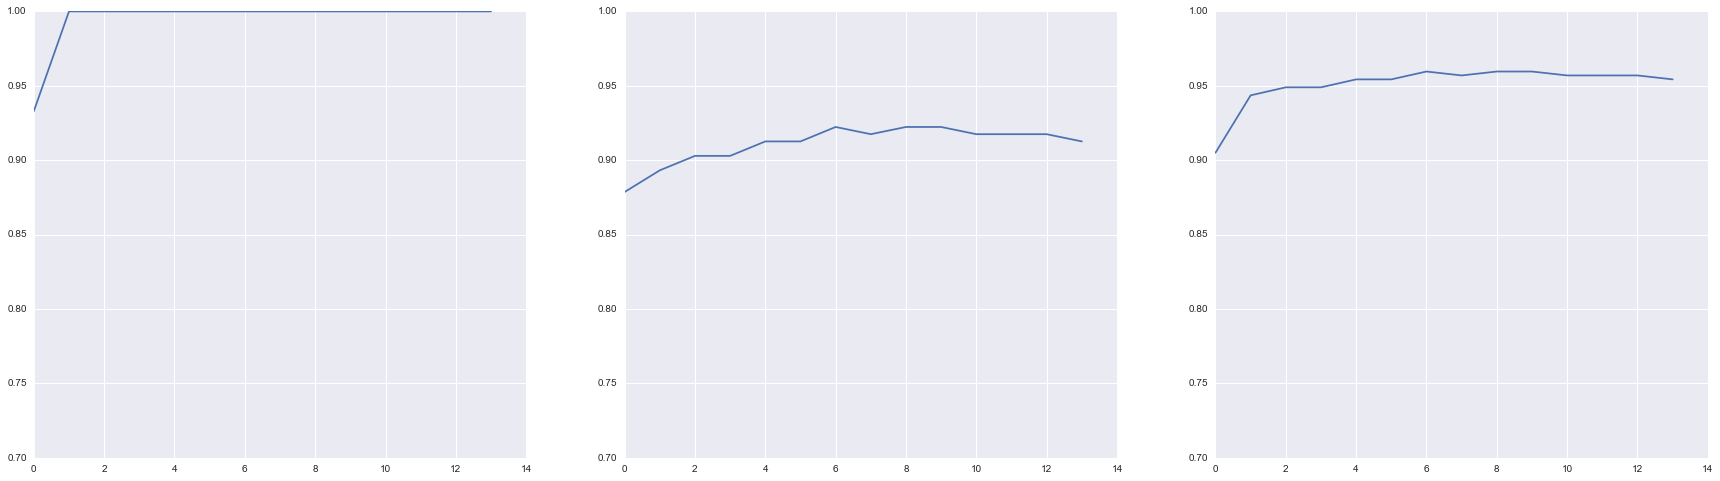

________________________________________________________________________________________________________________
蕾絲 162116
              worst      best  improved
iteration  0.000000  1.000000       NaN
f1         0.956522  0.985507  0.028986
recall     0.970588  1.000000  0.029412
precision  0.942857  0.971429  0.028571


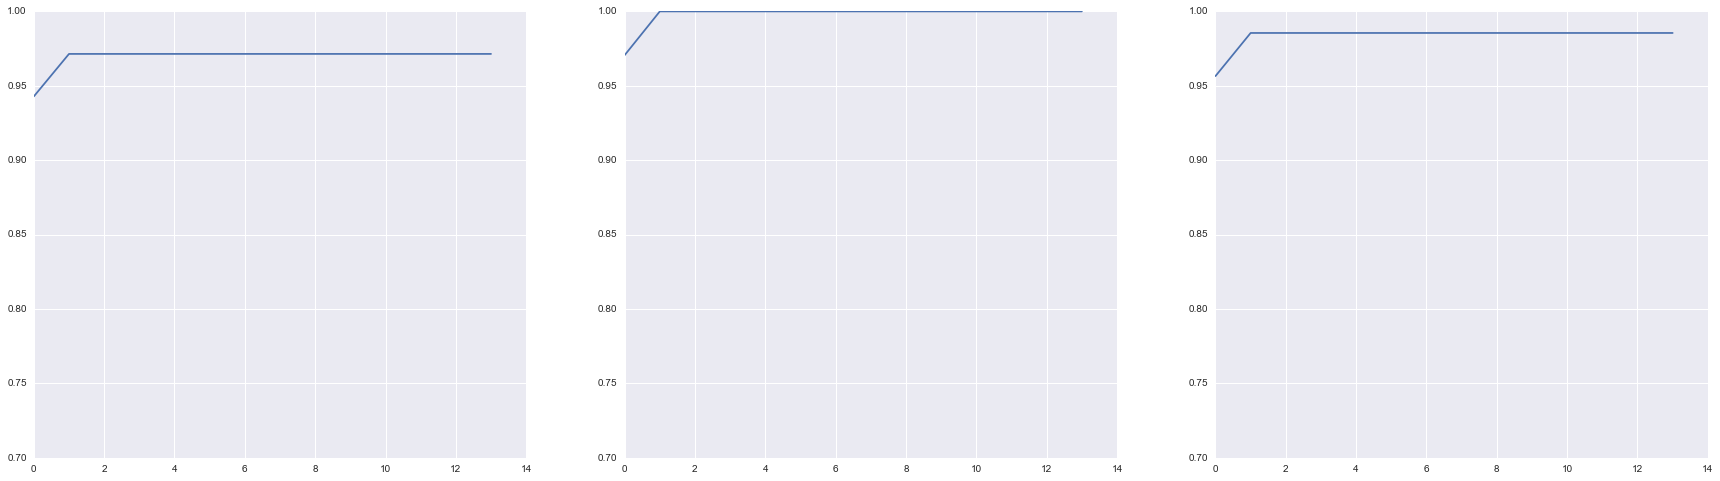

________________________________________________________________________________________________________________
半身裙 1623
              worst       best  improved
iteration  0.000000  13.000000       NaN
f1         0.917160   0.984802  0.067643
recall     0.928144   0.970060  0.041916
precision  0.906433   1.000000  0.093567


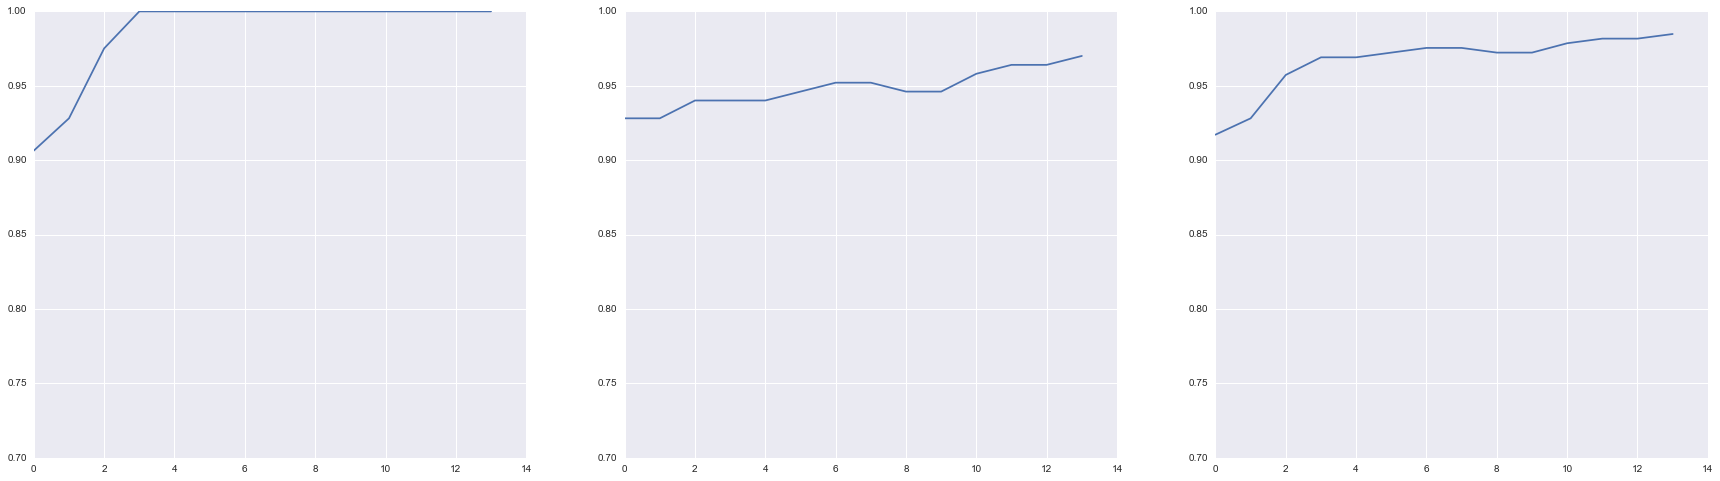

________________________________________________________________________________________________________________
背心吊帶 121412004
              worst      best  improved
iteration  0.000000  9.000000       NaN
f1         0.833333  0.911628  0.078295
recall     0.811966  0.837607  0.025641
precision  0.855856  1.000000  0.144144


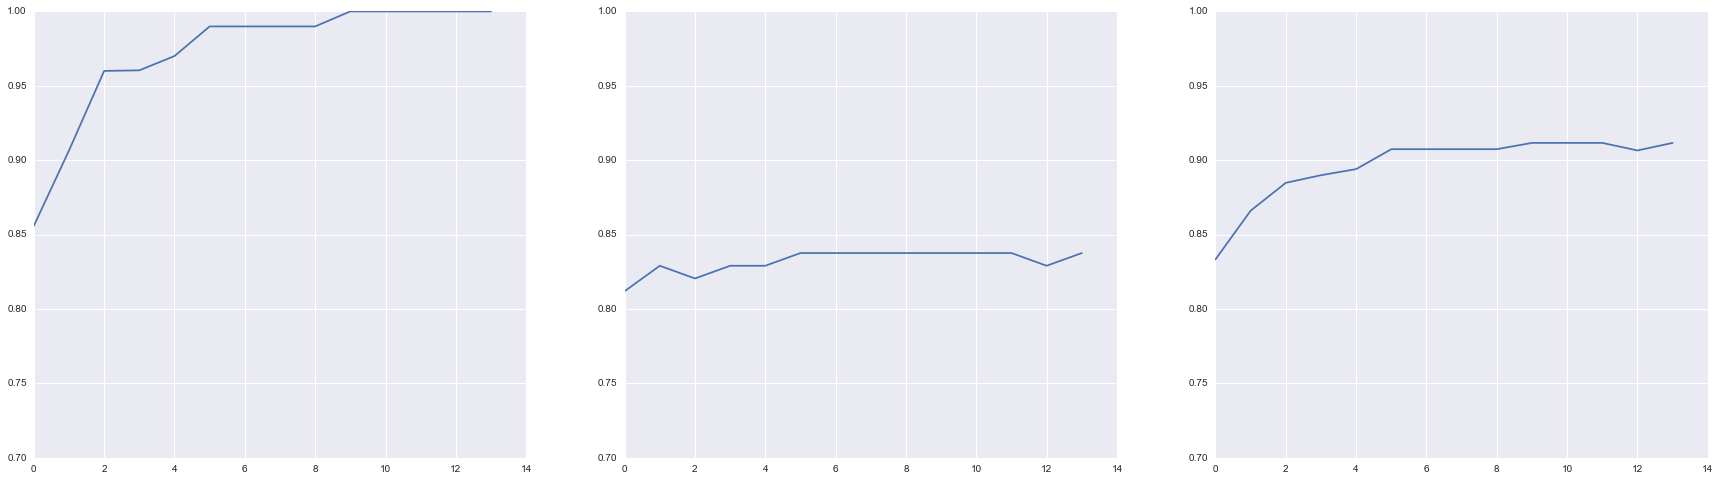

________________________________________________________________________________________________________________
村杉 162104
              worst       best  improved
iteration  0.000000  11.000000       NaN
f1         0.738255   0.853333  0.115078
recall     0.639535   0.744186  0.104651
precision  0.873016   1.000000  0.126984


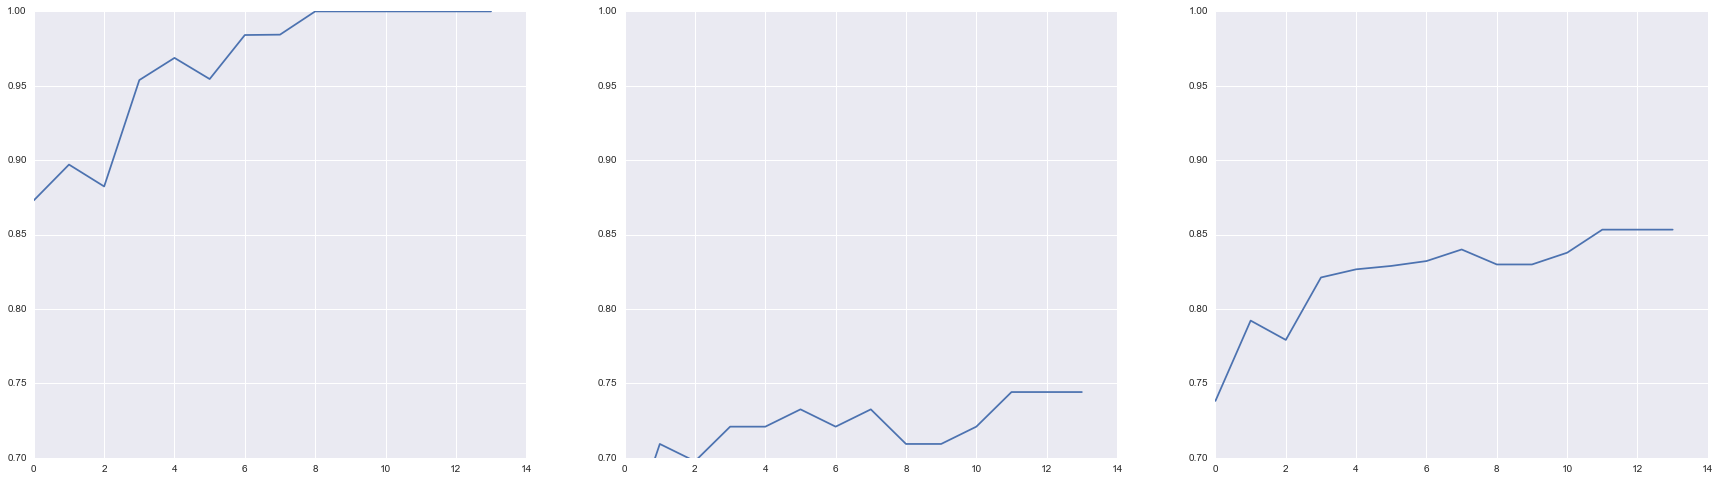

________________________________________________________________________________________________________________
毛衣 162103
              worst      best  improved
iteration  0.000000  2.000000       NaN
f1         0.952381  0.979592  0.027211
recall     0.933333  0.960000  0.026667
precision  0.972222  1.000000  0.027778


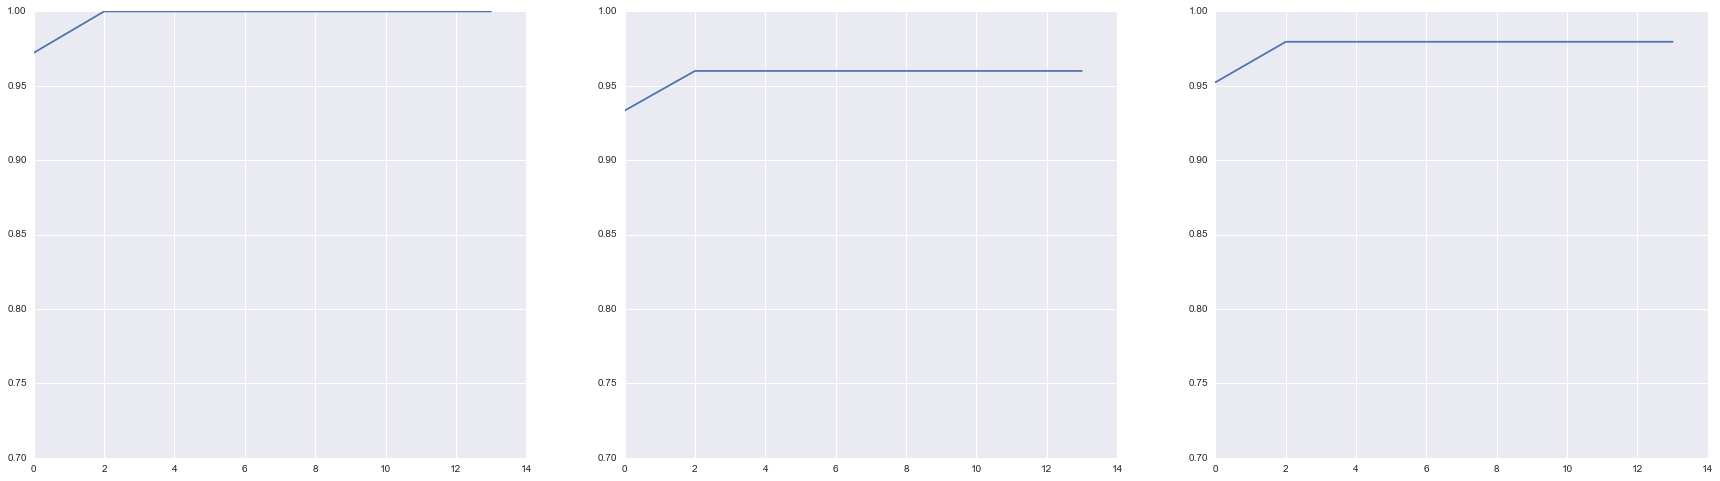

________________________________________________________________________________________________________________
風衣 50008901
              worst      best  improved
iteration  0.000000  7.000000       NaN
f1         0.838174  0.932127  0.093952
recall     0.855932  0.872881  0.016949
precision  0.821138  1.000000  0.178862


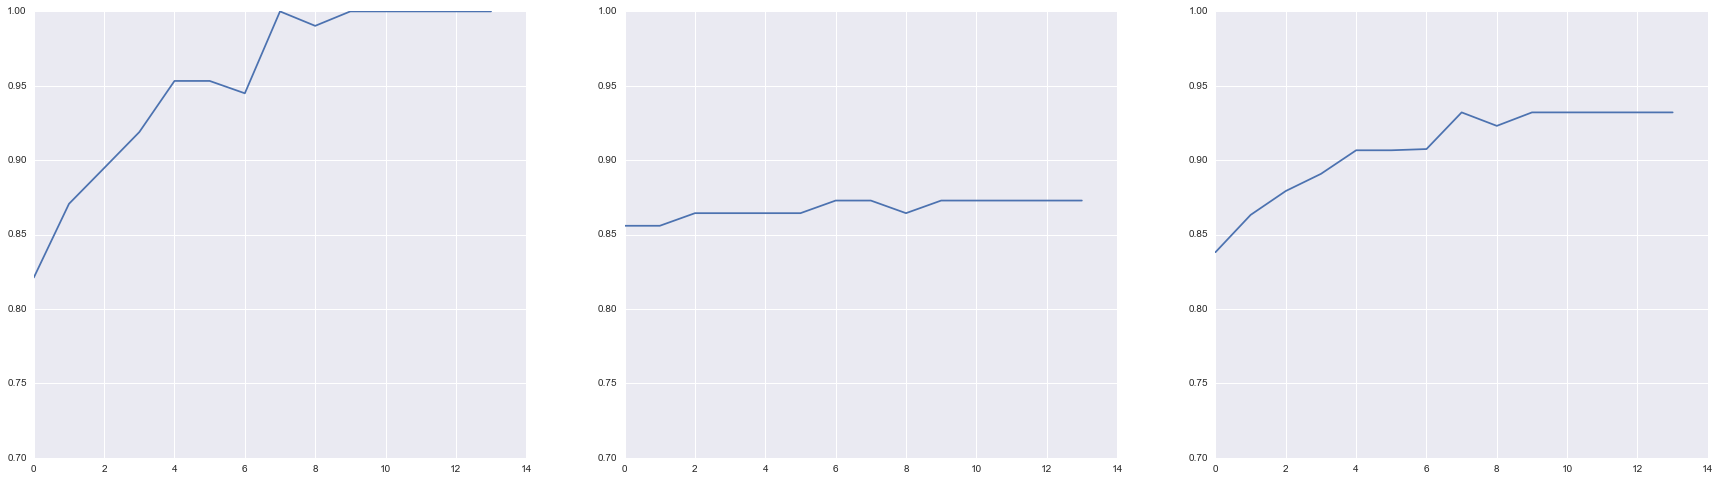

________________________________________________________________________________________________________________
短外套 50011277
              worst       best  improved
iteration  0.000000  10.000000       NaN
f1         0.822695   0.955882  0.133187
recall     0.816901   0.915493  0.098592
precision  0.828571   1.000000  0.171429


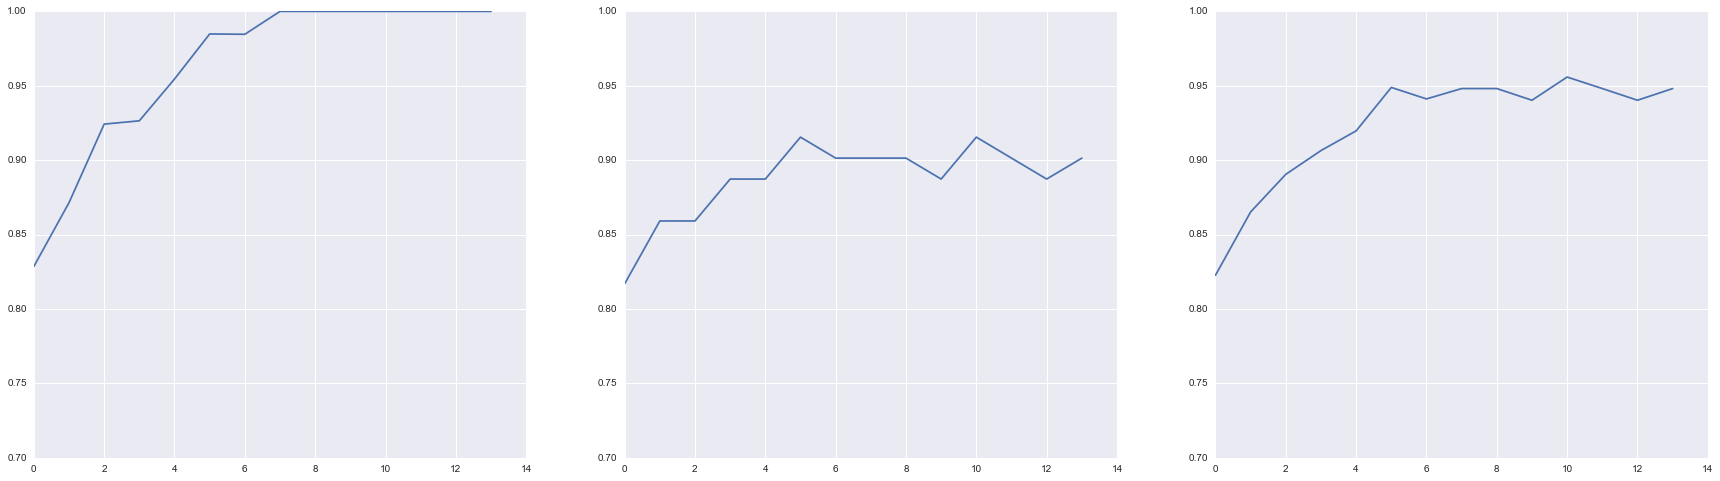

________________________________________________________________________________________________________________
DONE


In [66]:
for category in categoryID_list[:]:
    
    print category_dict[category], category
    
    p = prediction_dict[category]
    y = y_test_dict[category]

    preci_list, recall_list, f1_list = [], [], []
    
    for number_of_models in range(8, len(p.columns), 8):
        temp_pred = p.iloc[:, :number_of_models].median(axis=1)
        temp_pred = [1 if x > 0.5 else 0 for x in temp_pred]
        preci_list.append(precision_score(y, temp_pred))
        recall_list.append(recall_score(y, temp_pred))
        f1_list.append(f1_score(y, temp_pred))
    
    worst_i = f1_list.index(min(f1_list))
    best_i = f1_list.index(max(f1_list))
    
    comparison = pd.DataFrame()
    comparison = pd.concat([comparison, pd.Series([worst_i, f1_list[worst_i], recall_list[worst_i], preci_list[worst_i]])], axis=1)
    comparison = pd.concat([comparison, pd.Series([best_i, f1_list[best_i], recall_list[best_i], preci_list[best_i]])], axis=1)
    comparison = pd.concat([comparison, 
                            pd.Series([np.nan, f1_list[best_i] - f1_list[worst_i] ,
                                       recall_list[best_i] - recall_list[worst_i],
                                       preci_list[best_i] - preci_list[worst_i]])], axis=1)
    comparison.index = ['iteration', 'f1', 'recall', 'precision']
    comparison.columns = ['worst', 'best', 'improved']
    print comparison
    
    
    fig = plt.figure(figsize=(30, 8))
    for i, score in zip(range(1, 4), [preci_list, recall_list, f1_list]):
        ax = fig.add_subplot(1, 3, i)
        ax.set_ylim([0.7, 1.0])
#         ax.set_xlim([0, 88])
        pred_df = pd.DataFrame(score)

        plt.plot(pred_df)
    plt.show()
    
    print '________________________________________________________________________________________________________________'
print 'DONE'